In [1]:
# Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/naf/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


' If SSL error _ssl.c:997: \n    pip install --upgrade certifi'

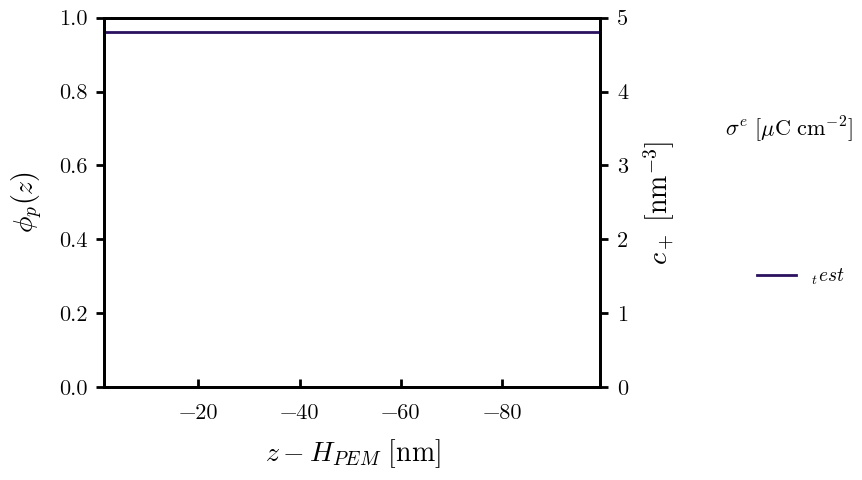

In [ ]:
mcs = mpl.colormaps['magma'].resampled(7)(range(5,0,-1))[::-1]
dz = 0.05 ## FIX PLOT SHIFTS IN CODE ITSELF, RIGHT NOW JUST GUESSING
Lz_PEM, phi_PEM = 199.4, 0.96
pat = 'ph'
eat = 'el'
fin = '.dat'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
# for i,c in zip(['10', '5', '0', 'n5', 'n10'],mcs):
for i,c in zip(['_test'],mcs):
    ph = tjy.phread(GIT+pat+i+fin, block=5)
    ax.plot(np.arange(-Lz_PEM,0.0001,0.1), [phi_PEM]*int(round(Lz_PEM/0.10)+1), c=c)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(i))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+fin)
    rax.plot(el.z-Lz_PEM+dz, el.ca,c=c, ls=':')
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z - H_{PEM}\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (-1.5, max(el.z)-Lz_PEM+2*dz),
    ylim= (0, 1),
)    
rax.set(
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (0, 5)
)
ax.text(1.38, 0.68, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.25), ncol=1)

tjy.ticks([ax, rax])

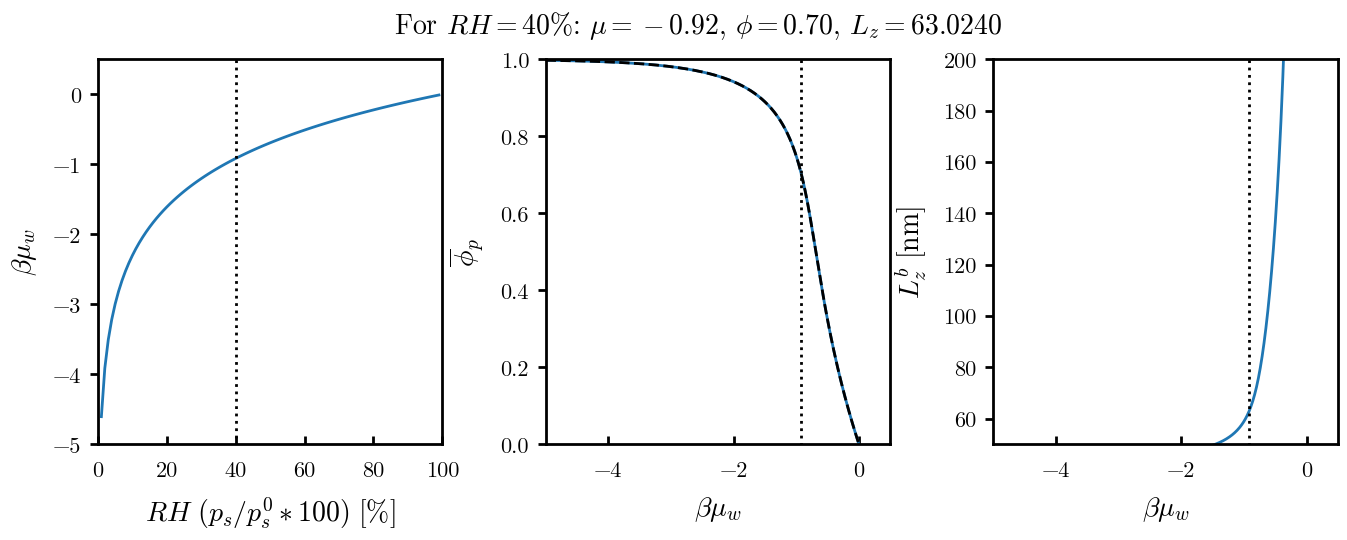

In [25]:
## Inputs
chi = 2.00
patm = 1.0 # ext. pressure = 1 atm

# Primary input
RH = 0.40

## Constants
nu = 0.069 #[nm3]
n_p, N, A  = 320, 100, 50 # [1], [1], [nm2]
kT = 1.38e-23 * 293 #[J]
p_kT = patm*101.3 / 1000 * (1e2/1e9)**3 / kT 

mukT_phi = lambda x: np.log(1-x) - x*(1-1/N) + chi*np.power(x,2) + p_kT*nu
mukT_P = lambda x: np.log(x)

fig, axs = plt.subplots(1,3, figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

Ps = np.arange(0.01, 1, 0.01)
axs[0].plot(Ps*100, mukT_P(Ps))

phis = np.arange(0.999,0.00,-0.001)
axs[1].plot(mukT_phi(phis), phis)
fit = UnivariateSpline(mukT_phi(phis), phis, s=1e-12)
mus = np.arange(-5, 0, 0.01)
axs[1].plot(mus, fit(mus),'--k')

axs[2].plot(mus, n_p*N*nu/fit(mus)/A)

mu = mukT_P(RH)
plt.suptitle(r'For $RH = {:.0f}$%: $\mu = {:.2f}$, $\phi = {:.2f}$, $L_z = {:.4f}$'.format(RH*100, mu, fit(mu), n_p*N*nu/fit(mu)/A), fontsize=20, fontfamily='serif')
axs[0].plot([RH*100]*2, [-100,100], ':k')
axs[1].plot([mu]*2, [-100,100], ':k')
axs[2].plot([mu]*2, [0,500], ':k')

axs[0].set(
    xlim= (0,100),
    ylim= (-5,0.5),
    xlabel=r'$RH\ (p_s/p_s^0*100)\ [\%]$',
    ylabel=r'$\beta\mu_w$',
)
axs[1].set(
    xlim= (-5,0.5),
    ylim= (0,1.0),
    xlabel=r'$\beta\mu_w$',
    ylabel=r'$\overline{\phi}_p$',
)
axs[2].set(
    xlim= (-5,0.5),
    ylim= (50, 200),
    ylabel=r'$L_z^b\ [\mathrm{nm}]$',
    xlabel=r'$\beta\mu_w$',
)
tjy.ticks(axs)

# Analytical

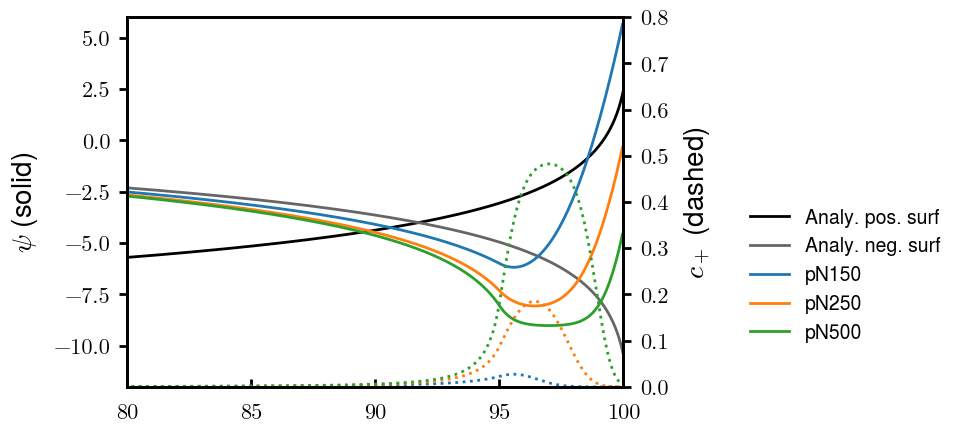

In [44]:
def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': data[1], 'ca': data[2]})
    return el

f,ax = plt.subplots(1,1)
tax = ax.twinx()
el = elread(GIT+'ph_s010_N1000.dat')
ax.plot(el.z, -1*el.psi-8, 'k', label='Analy. pos. surf')
ax.plot(el.z, el.psi, '0.4', label='Analy. neg. surf')
# tax.plot(el.z, el.ca, 'k:')

for i in ['pN150', 'pN250', 'pN500']:
    el = elread(GIT+'ph_sP10_{:s}.dat'.format(i))
    ax.plot(el.z, el.psi, label=i)
    tax.plot(el.z, el.ca, ':')

ax.legend(loc=(1.24,0.1))
ax.set_ylabel(r'$\psi$ (solid)')
tax.set_ylabel(r'$c_+$ (dashed)')
tax.set_ylim(0,0.8)
ax.set_xlim(80,100)
ax.set_ylim(-12,6)
tjy.ticks([ax,tax])

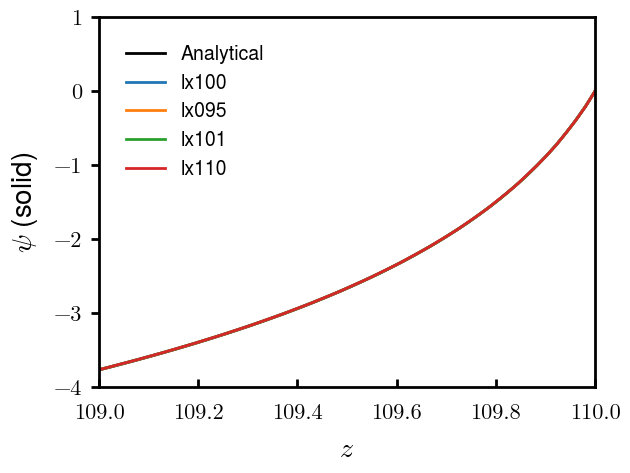

In [95]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

surf_c = 20e-20# C/nm2
lGC = 2*eps0*epsw/(surf_c/e)

fig, ax = plt.subplots(1,1)

psi = lambda z: -2*np.log(1+z/lGC)
z = np.arange(0,110,0.0001)
ax.plot(z[::-1], psi(z), 'k', label='Analytical')

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

shift = lambda el: 110-el.z[len(el.z)-1]
el = elread(GIT+'ph_sN20_RLx100.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C0', label='lx100')
el = elread(GIT+'ph_sN20_RLx095.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C1', label='lx095')
el = elread(GIT+'ph_sN20_RLx101.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C2', label='lx101')
el = elread(GIT+'ph_sN20_RLx110.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C3', label='lx110')

ax.set_xlim(109,110)
ax.set_xlabel(r'$z$')
ax.set_ylim(-4,1)
ax.set_ylabel(r'$\psi$ (solid)')
ax.legend(loc=2)
tjy.ticks()

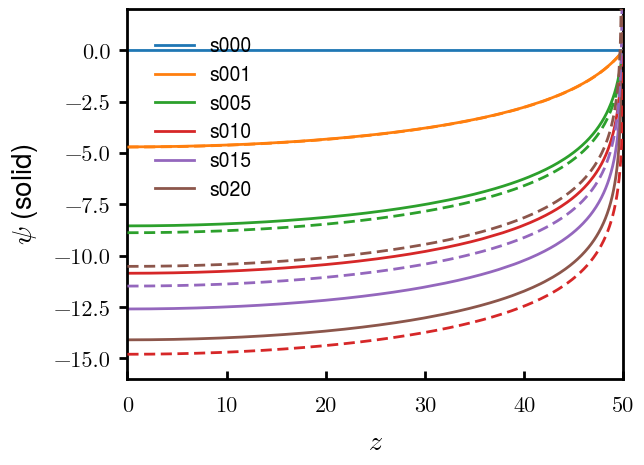

In [115]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

#Cms = [5.14659e-05, 5.44397e-05, 5.48560e-05, 5.50505e-05] # Numerically found 
Cms = [0, 1.9492e-04, 2.1761e-04, 2.2075e-04, 2.2183e-04, 2.2239e-04] # Numerically found
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip([0, 1,5,10,15,20], ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    surf_c = i*1e-20 # C/nm2
    if Cm != 0: 
        # lGC = 2*eps0*epsw/(surf_c/e)
        # psi = lambda z: -2*np.log(1+z/lGC)
        # cat = lambda z: 2*eps0*epsw/lGC**2 * np.power((1 + z/lGC), -2)
        # ax.plot(z[::-1], psi(z), c=c, zorder=5,ls=':')

        L = 49.99
        z = np.arange(0, L, 0.001)
        lam = np.sqrt(eps0*epsw / Cm)
        psi_h = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
        ax.plot(z, -psi_h(z)+psi_h(L), c=c, zorder=5,ls=(0,(4,2)))

    ch = 's{0:03d}'.format(int(i))
    el = elread(GIT+'el_full_{:s}.dat'.format(ch))
    ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='s{:03d}'.format(i))

ax.set_xlim(0,50)
ax.set_xlabel(r'$z$')
ax.set_ylim(-16,2)
ax.set_ylabel(r'$\psi$ (solid)')
ax.legend()
tjy.ticks()

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.7457972013368075

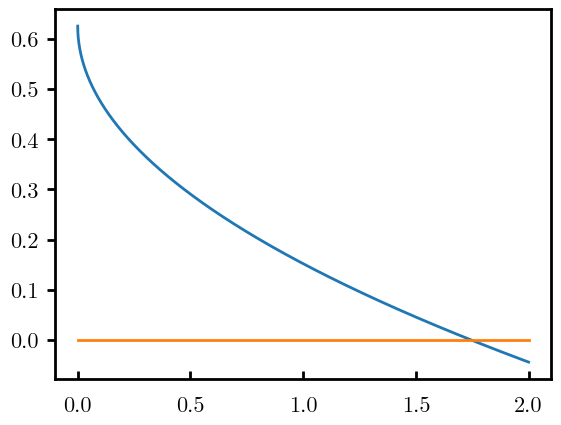

In [142]:
from scipy.optimize import root_scalar
eps = eps0*epsw
f = lambda x,h,c: -np.sqrt(2.0*eps*x)*np.tanh(h*np.sqrt(x/2.0/eps)) + c/e

plt.plot(np.arange(0,2,0.0001), f(np.arange(0,2,0.0001),50,10e-20))
plt.plot([0,2],[0,0])
tjy.ticks()

sol = root_scalar(f, args=(50, 10e-20), bracket=[1e-10, 1e2], method='brentq', rtol=1e-12, xtol=1e-12)
sol

lGC = 1.79001e-01
BC = 1.25000e+00
cat(0) = 6.98319e+00
analy. surf_charge err: -2.0547538070836423e-05
numer. surf_charge err: -0.00841489276259182


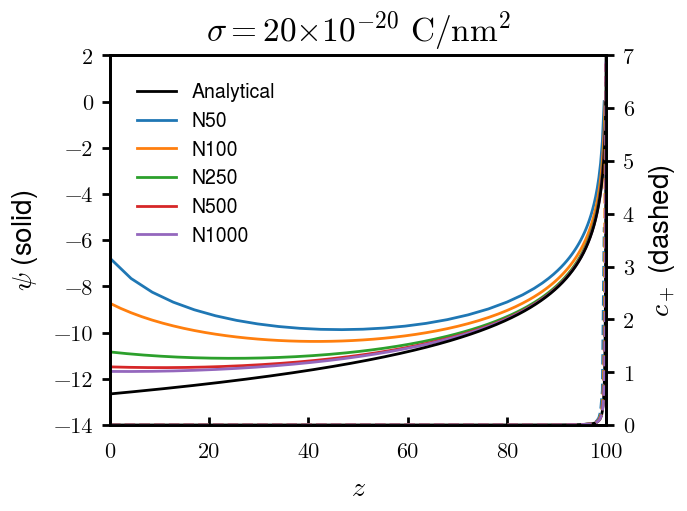

In [82]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

surf_c = 20e-20# C/nm2
lGC = 2*eps0*epsw/(surf_c/e)
print("lGC = {:10.5e}".format(lGC), sep='\t')
print("BC = {:10.5e}".format(surf_c/e))

fig, ax = plt.subplots(1,1)
tax = ax.twinx()

psi = lambda z: -2*np.log(1+z/lGC)
cat = lambda z: 2*eps0*epsw/lGC**2 * np.power((1 + z/lGC), -2)
z = np.arange(0,100,0.001)
ax.plot(z[::-1], psi(z), 'k', label='Analytical', zorder=5)
tax.plot(z[::-1], cat(z), 'k')
print("cat(0) = {:10.5e}".format(cat(0)))

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

lab = 's{0:03d}'.format(int(surf_c*1e20))
el = elread(GIT+'ph_{:s}_N50.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C0', label='N50')
tax.plot(el.z, el.ca, c='C0', ls='--')
el = elread(GIT+'ph_{:s}_N100.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C1', label='N100')
tax.plot(el.z, el.ca, c='C1', ls='--')
el = elread(GIT+'ph_{:s}_N250.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C2', label='N250')
tax.plot(el.z, el.ca, c='C2', ls='--')
el = elread(GIT+'ph_{:s}_N500.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C3', label='N500')
tax.plot(el.z, el.ca, c='C3', ls='--')
el = elread(GIT+'ph_{:s}_N1000.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C4', label='N1000')
tax.plot(el.z, el.ca, c='C4', ls='--')

# for i in el.z: plt.plot([i,i], [-10,10], zorder=2, lw=0.1, c='k')

# Error of surface charge boundary condition
print("analy. surf_charge err:", (((-3*psi(z[0]) +4*psi(z[1]) - psi(z[2])) / 2/(z[1] - z[0]) *-eps0*epsw) - surf_c/e)/(surf_c/e) )
print("numer. surf_charge err:", ((-(3*el.psi[len(el.psi)-1] - 4*el.psi[len(el.psi)-2] +el.psi[len(el.psi)-3]) / 2/(el.z[len(el.z)-1] - el.z[len(el.z)-2]) *-eps0*epsw)- surf_c/e)/(surf_c/e) )

plt.title(r'$\sigma={:1.0f}$'.format(surf_c*1e20)+r'$\times 10^{-20}\ \mathrm{C/nm^2}$', fontsize=24)
ax.set_xlim(0,100)
ax.set_xlabel(r'$z$')
ax.set_ylim(-14,2)
ax.set_ylabel(r'$\psi$ (solid)')
tax.set_ylim(0, 7.00)
tax.set_ylabel(r'$c_+$ (dashed)')
ax.legend(loc=0)
tjy.ticks([ax,tax])

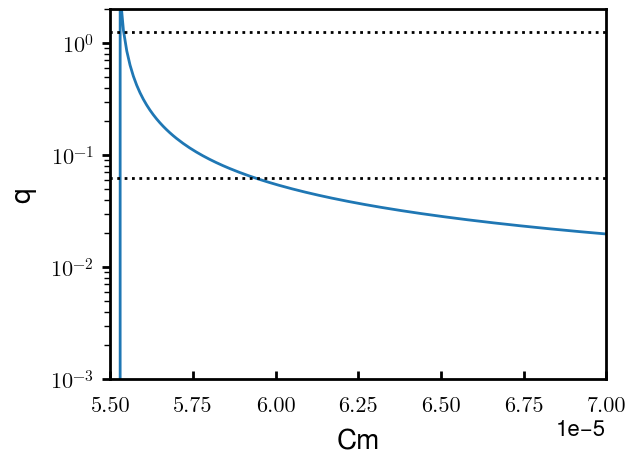

In [422]:
def qforward(Cm, h=200):
    eps = 0.11187582375000002 
    q = -1.0*np.sqrt(2.0*eps*Cm)*np.tan(h/2 * np.sqrt( Cm/2./eps ))
    return q

Cm = np.arange(0,20e-05,1e-07)
plt.plot(Cm, qforward(Cm))
plt.plot([0.00005, 0.00020], [1e-20/1.6e-19]*2,  ':k')
plt.plot([0.00005, 0.00020], [20e-20/1.6e-19]*2, ':k')

plt.xlim(5.5e-05,7e-05)
plt.yscale('log')
plt.ylim(1e-03,20e-01)

plt.xlabel('Cm')
plt.ylabel('q')
tjy.ticks()

In [4]:
# Harsh analytical solution
## phi = phim + kbT/ze * ln ( cos^2( x/lambda/sqrt(2) ) ), where phim is phi at midplane for bound -q/eps
## lambda = sqrt( eps*kbT / (z^2 e^2 Cm) ), where Cm is midplane concentration where dphi/dz = 0
from scipy.optimize import fsolve

def qforward(Cm, h=200):
    eps = 0.11187582375000002 #eps0*80*kbT*length/charge/charge
    q = -1.0*np.sqrt(2.0*eps*Cm)*np.tan(h/2 * np.sqrt( Cm/2./eps ))
    return q

def get_err(fname, Cm):
    eps = 0.11187582375000002
    el = elread(fname)
    
    # func = lambda x,h,c: qforward(x,h) - c/1.6e-19
    # Cm = fsolve(func, 6.0e-05, args=(el.z[len(el.z)-1]*2,1e-20))[0]
    # print(Cm)
    
    lam = np.sqrt(eps / Cm)
    psi = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
    err = 0
    for i in range(len(el.z)): err += np.power(el.psi[i] + psi(el.z[i]),2)
    return np.sqrt(err)

Cms = [5.14659e-05, 5.44397e-05, 5.48560e-05, 5.50505e-05]
Ns = [50, 100, 250, 500, 1000, 2500, 5000]
stNs = ['N{:d}'.format(i) for i in Ns]
err1 = [get_err(GIT+'ph_s001_{:s}.dat'.format(i), Cms[0]) for i in stNs ]
err5 = [get_err(GIT+'ph_s005_{:s}.dat'.format(i), Cms[1]) for i in stNs ]
# err10= [get_err(GIT+'ph_s010_{:s}.dat'.format(i), 5.48560e-05) for i in stNs ]
# err20= [get_err(GIT+'ph_s020_{:s}.dat'.format(i), 5.51615e-05) for i in stNs ]

NameError: name 'elread' is not defined

In [ ]:
xan = np.arange(55,90,0.1)
yan = np.power(1/xan, 2)
plt.plot(xan, 5000*yan, 'k')
plt.plot(Ns, err1, 'o-', markerfacecolor='w', label=r'$\sigma = 1\times 10^{-20}$')
plt.plot(Ns, err5, 'o-', markerfacecolor='w', label=r'$\sigma = 5\times 10^{-20}$')
# plt.plot(Ns, err10, 'o-', markerfacecolor='w', label=r'$\sigma = 10\times 10^{-20}$')
# plt.plot(Ns, err20, 'o-', markerfacecolor='w', label=r'$\sigma = 20\times 10^{-20}$')

plt.xlim(40, 6000)
plt.ylim(1e-03, 200)
plt.legend()
plt.ylabel(r'$\vert \psi - \overline{\psi}\vert_2$')
plt.xlabel(r'$N$')
plt.yscale('log')
plt.xscale('log')
tjy.ticks()

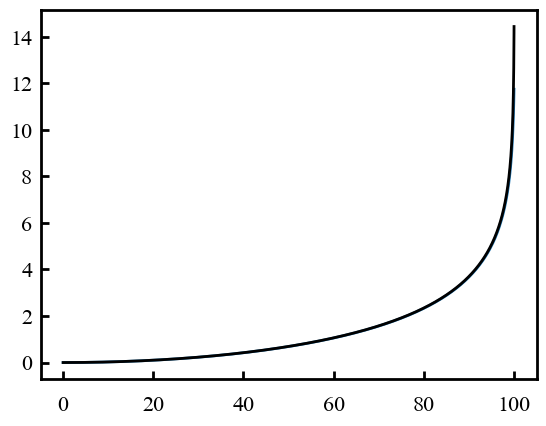

In [3]:
eps = 0.11187582375000002
Cms = [5.14659e-05, 5.44397e-05, 5.48560e-05, 5.51615e-05]

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

Cm = Cms[3]
lam = np.sqrt(eps / Cm)
psi = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
    
el = elread(GIT+'ph_s020_N5000.dat')
plt.plot(el.z,el.psi)
plt.plot(el.z, -psi(el.z), 'k')

# plt.xlim(99,100.1)
tjy.ticks()

746


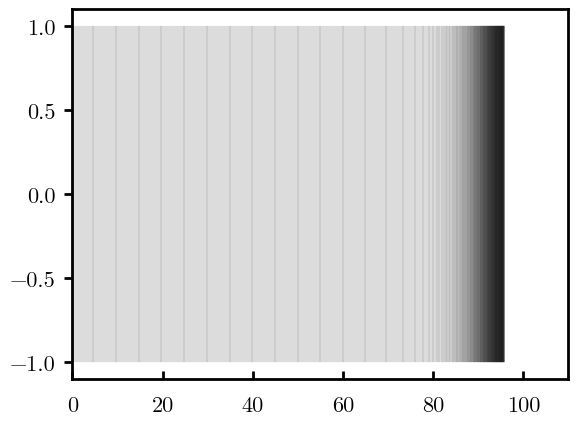

In [73]:
# for i in ['N50', 'N100', 'N250', 'N500', 'N1000']:
for i in ['RLx095']:
    f,ax = plt.subplots(1,1)
    el = elread(GIT+'ph_sN20_{:s}.dat'.format(i))
    for j in el.z: plt.plot([j,j], [-1,1], 'k', lw=0.1)
    print(len(el.z))
    plt.xlim(0,110)
    tjy.ticks()


In [294]:
# Converting wolfram cloud mesh to textfile
data = [0.000,0.00196926,0.00393799,0.0059062,0.00787389,0.00984105,0.0118077,0.0137738,0.0157394,0.0177045,0.019669,0.021633,0.0235965,0.0255595,0.027522,0.0294839,0.0314454,0.0334063,0.0353667,0.0373266,0.0392859,0.0412448,0.0432031,0.0451609,0.0471182,0.049075,0.0510313,0.0529871,0.0549423,0.0568971,0.0588513,0.060805,0.0627582,0.0647109,0.0666631,0.0686148,0.070566,0.0725167,0.0744669,0.0764165,0.0783657,0.0803143,0.0822625,0.0842101,0.0861573,0.0881039,0.09005,0.0919957,0.0939408,0.0958854,0.0978296,0.0997732,0.101716,0.103659,0.105601,0.107543,0.109484,0.111425,0.113365,0.115304,0.117244,0.119182,0.12112,0.123058,0.124995,0.126932,0.128868,0.130804,0.132739,0.134674,0.136608,0.138542,0.140475,0.142408,0.14434,0.146272,0.148203,0.150134,0.152064,0.153994,0.155924,0.157853,0.159781,0.161709,0.163636,0.165563,0.16749,0.169416,0.171341,0.173266,0.175191,0.177115,0.179038,0.180962,0.182884,0.184806,0.186728,0.188649,0.19057,0.19249,0.19441,0.196329,0.198248,0.200167,0.202085,0.204002,0.205919,0.207835,0.209751,0.211667,0.213582,0.215497,0.217411,0.219324,0.221238,0.22315,0.225063,0.226974,0.228886,0.230797,0.232707,0.234617,0.236526,0.238435,0.240344,0.242252,0.24416,0.246067,0.247973,0.24988,0.251785,0.253691,0.255596,0.2575,0.259404,0.261307,0.263211,0.265113,0.267015,0.268917,0.270818,0.272719,0.274619,0.276519,0.278418,0.280317,0.282216,0.284114,0.286011,0.287909,0.289805,0.291701,0.293597,0.295493,0.297387,0.299282,0.301176,0.303069,0.304962,0.306855,0.308747,0.310639,0.31253,0.314421,0.316312,0.318202,0.320091,0.32198,0.323869,0.325757,0.327645,0.329532,0.331419,0.333306,0.335192,0.337077,0.338962,0.340847,0.342731,0.344615,0.346498,0.348381,0.350264,0.352146,0.354028,0.355909,0.35779,0.35967,0.36155,0.363429,0.365308,0.367187,0.369065,0.370943,0.37282,0.374697,0.376574,0.37845,0.380325,0.3822,0.384075,0.385949,0.387823,0.389697,0.39157,0.393443,0.395315,0.397186,0.399058,0.400929,0.402799,0.404669,0.406539,0.408408,0.410277,0.412145,0.414013,0.415881,0.417748,0.419615,0.421481,0.423347,0.425212,0.427077,0.428942,0.430806,0.43267,0.434533,0.436396,0.438259,0.440121,0.441983,0.443844,0.445705,0.447565,0.449425,0.451285,0.453144,0.455003,0.456862,0.45872,0.460577,0.462434,0.464291,0.466148,0.468004,0.469859,0.471714,0.473569,0.475423,0.477277,0.479131,0.480984,0.482837,0.484689,0.486541,0.488392,0.490243,0.492094,0.493944,0.495794,0.497644,0.499493,0.501342,0.50319,0.505038,0.506885,0.508732,0.510579,0.512425,0.514271,0.516117,0.517962,0.519807,0.521651,0.523495,0.525339,0.527182,0.529024,0.530867,0.532709,0.53455,0.536391,0.538232,0.540073,0.541913,0.543752,0.545591,0.54743,0.549269,0.551107,0.552944,0.554782,0.556619,0.558455,0.560291,0.562127,0.563962,0.565797,0.567632,0.569466,0.5713,0.573133,0.574966,0.576799,0.578631,0.580463,0.582294,0.584126,0.585956,0.587787,0.589617,0.591446,0.593275,0.595104,0.596933,0.598761,0.600589,0.602416,0.604243,0.606069,0.607896,0.609721,0.611547,0.613372,0.615197,0.617021,0.618845,0.620668,0.622492,0.624314,0.626137,0.627959,0.629781,0.631602,0.633423,0.635243,0.637064,0.638884,0.640703,0.642522,0.644341,0.646159,0.647977,0.649795,0.651612,0.653429,0.655246,0.657062,0.658878,0.660693,0.662508,0.664323,0.666137,0.667951,0.669765,0.671578,0.673391,0.675203,0.677016,0.678827,0.680639,0.68245,0.684261,0.686071,0.687881,0.689691,0.6915,0.693309,0.695118,0.696926,0.698734,0.700541,0.702348,0.704155,0.705962,0.707768,0.709573,0.711379,0.713184,0.714988,0.716793,0.718597,0.7204,0.722203,0.724006,0.725809,0.727611,0.729413,0.731214,0.733016,0.734816,0.736617,0.738417,0.740217,0.742016,0.743815,0.745614,0.747412,0.74921,0.751008,0.752805,0.754602,0.756399,0.758195,0.759991,0.761787,0.763582,0.765377,0.767171,0.768966,0.77076,0.772553,0.774346,0.776139,0.777932,0.779724,0.781516,0.783307,0.785098,0.786889,0.78868,0.79047,0.79226,0.794049,0.795838,0.797627,0.799415,0.801204,0.802991,0.804779,0.806566,0.808353,0.810139,0.811925,0.813711,0.815496,0.817282,0.819066,0.820851,0.822635,0.824419,0.826202,0.827985,0.829768,0.831551,0.833333,0.835114,0.836896,0.838677,0.840458,0.842238,0.844019,0.845798,0.847578,0.849357,0.851136,0.852914,0.854693,0.856471,0.858248,0.860025,0.861802,0.863579,0.865355,0.867131,0.868907,0.870682,0.872457,0.874232,0.876006,0.87778,0.879554,0.881327,0.8831,0.884873,0.886645,0.888417,0.890189,0.89196,0.893732,0.895502,0.897273,0.899043,0.900813,0.902582,0.904352,0.906121,0.907889,0.909658,0.911426,0.913193,0.914961,0.916728,0.918494,0.920261,0.922027,0.923793,0.925558,0.927323,0.929088,0.930853,0.932617,0.934381,0.936144,0.937908,0.939671,0.941433,0.943196,0.944958,0.94672,0.948481,0.950242,0.952003,0.953764,0.955524,0.957284,0.959043,0.960803,0.962562,0.96432,0.966079,0.967837,0.969595,0.971352,0.973109,0.974866,0.976623,0.978379,0.980135,0.981891,0.983646,0.985401,0.987156,0.98891,0.990665,0.992418,0.994172,0.995925,0.997678,0.999431,1.00118,1.00294,1.00469,1.00644,1.00819,1.00994,1.01169,1.01344,1.01519,1.01694,1.01869,1.02044,1.02219,1.02394,1.02569,1.02743,1.02918,1.03093,1.03268,1.03442,1.03617,1.03792,1.03966,1.04141,1.04315,1.0449,1.04664,1.04839,1.05013,1.05187,1.05362,1.05536,1.0571,1.05885,1.06059,1.06233,1.06407,1.06582,1.06756,1.0693,1.07104,1.07278,1.07452,1.07626,1.078,1.07974,1.08148,1.08322,1.08496,1.08669,1.08843,1.09017,1.09191,1.09364,1.09538,1.09712,1.09885,1.10059,1.10232,1.10406,1.1058,1.10753,1.10926,1.111,1.11273,1.11447,1.1162,1.11793,1.11967,1.1214,1.12313,1.12486,1.1266,1.12833,1.13006,1.13179,1.13352,1.13525,1.13698,1.13871,1.14044,1.14217,1.1439,1.14563,1.14736,1.14908,1.15081,1.15254,1.15427,1.15599,1.15772,1.15945,1.16117,1.1629,1.16463,1.16635,1.16808,1.1698,1.17153,1.17325,1.17498,1.1767,1.17842,1.18015,1.18187,1.18359,1.18532,1.18704,1.18876,1.19048,1.1922,1.19393,1.19565,1.19737,1.19909,1.20081,1.20253,1.20425,1.20597,1.20769,1.20941,1.21113,1.21284,1.21456,1.21628,1.218,1.21972,1.22143,1.22315,1.22487,1.22658,1.2283,1.23001,1.23173,1.23345,1.23516,1.23688,1.23859,1.24031,1.24202,1.24373,1.24545,1.24716,1.24887,1.25059,1.2523,1.25401,1.25572,1.25744,1.25915,1.26086,1.26257,1.26428,1.26599,1.2677,1.26941,1.27112,1.27283,1.27454,1.27625,1.27796,1.27967,1.28138,1.28308,1.28479,1.2865,1.28821,1.28991,1.29162,1.29333,1.29503,1.29674,1.29845,1.30015,1.30186,1.30356,1.30527,1.30697,1.30868,1.31038,1.31208,1.31379,1.31549,1.31719,1.3189,1.3206,1.3223,1.32401,1.32571,1.32741,1.32911,1.33081,1.33251,1.33421,1.33591,1.33761,1.33931,1.34101,1.34271,1.34441,1.34611,1.34781,1.34951,1.35121,1.35291,1.35461,1.3563,1.358,1.3597,1.3614,1.36309,1.36479,1.36648,1.36818,1.36988,1.37157,1.37327,1.37496,1.37666,1.37835,1.38005,1.38174,1.38344,1.38513,1.38682,1.38852,1.39021,1.3919,1.3936,1.39529,1.39698,1.39867,1.40036,1.40206,1.40375,1.40544,1.40713,1.40882,1.41051,1.4122,1.41389,1.41558,1.41727,1.41896,1.42065,1.42234,1.42402,1.42571,1.4274,1.42909,1.43078,1.43246,1.43415,1.43584,1.43753,1.43921,1.4409,1.44258,1.44427,1.44596,1.44764,1.44933,1.45101,1.4527,1.45438,1.45607,1.45775,1.45943,1.46112,1.4628,1.46449,1.46617,1.46785,1.46953,1.47122,1.4729,1.47458,1.47626,1.47794,1.47963,1.48131,1.48299,1.48467,1.48635,1.48803,1.48971,1.49139,1.49307,1.49475,1.49643,1.49811,1.49978,1.50146,1.50314,1.50482,1.5065,1.50818,1.50985,1.51153,1.51321,1.51488,1.51656,1.51824,1.51991,1.52159,1.52327,1.52494,1.52662,1.52829,1.52997,1.53164,1.53332,1.53499,1.53667,1.53834,1.54001,1.54169,1.54336,1.54503,1.54671,1.54838,1.55005,1.55172,1.5534,1.55507,1.55674,1.55841,1.56008,1.56175,1.56343,1.5651,1.56677,1.56844,1.57011,1.57178,1.57345,1.57512,1.57679,1.57846,1.58012,1.58179,1.58346,1.58513,1.5868,1.58847,1.59013,1.5918,1.59347,1.59514,1.5968,1.59847,1.60014,1.6018,1.60347,1.60513,1.6068,1.60847,1.61013,1.6118,1.61346,1.61513,1.61679,1.61846,1.62012,1.62178,1.62345,1.62511,1.62678,1.62844,1.6301,1.63176,1.63343,1.63509,1.63675,1.63841,1.64008,1.64174,1.6434,1.64506,1.64672,1.64838,1.65004,1.6517,1.65337,1.65503,1.65669,1.65835,1.66001,1.66166,1.66332,1.66498,1.66664,1.6683,1.66996,1.67162,1.67328,1.67493,1.67659,1.67825,1.67991,1.68156,1.68322,1.68488,1.68653,1.68819,1.68985,1.6915,1.69316,1.69482,1.69647,1.69813,1.69978,1.70144,1.70309,1.70475,1.7064,1.70806,1.70971,1.71136,1.71302,1.71467,1.71633,1.71798,1.71963,1.72128,1.72294,1.72459,1.72624,1.72789,1.72955,1.7312,1.73285,1.7345,1.73615,1.7378,1.73946,1.74111,1.74276,1.74441,1.74606,1.74771,1.74936,1.75101,1.75266,1.75431,1.75596,1.7576,1.75925,1.7609,1.76255,1.7642,1.76585,1.7675,1.76914,1.77079,1.77244,1.77409,1.77573,1.77738,1.77903,1.78067,1.78232,1.78397,1.78561,1.78726,1.78891,1.79055,1.7922,1.79384,1.79549,1.79713,1.79878,1.80042,1.80207,1.80371,1.80535,1.807,1.80864,1.81029,1.81193,1.81357,1.81522,1.81686,1.8185,1.82015,1.82179,1.82343,1.82507,1.82671,1.82836,1.83,1.83164,1.83328,1.83492,1.83656,1.8382,1.83984,1.84149,1.84313,1.84477,1.84641,1.84805,1.84969,1.85133,1.85297,1.8546,1.85624,1.85788,1.85952,1.86116,1.8628,1.86444,1.86608,1.86771,1.86935,1.87099,1.87263,1.87426,1.8759,1.87754,1.87918,1.88081,1.88245,1.88409,1.88572,1.88736,1.88899,1.89063,1.89227,1.8939,1.89554,1.89717,1.89881,1.90044,1.90208,1.90371,1.90535,1.90698,1.90862,1.91025,1.91188,1.91352,1.91515,1.91678,1.91842,1.92005,1.92168,1.92332,1.92495,1.92658,1.92821,1.92985,1.93148,1.93311,1.93474,1.93637,1.93801,1.93964,1.94127,1.9429,1.94453,1.94616,1.94779,1.94942,1.95105,1.95268,1.95431,1.95594,1.95757,1.9592,1.96083,1.96246,1.96409,1.96572,1.96735,1.96898,1.97061,1.97224,1.97386,1.97549,1.97712,1.97875,1.98038,1.982,1.98363,1.98526,1.98689,1.98851,1.99014,1.99177,1.99339,1.99502,1.99665,1.99827,1.9999,2.00152,2.00315,2.00478,2.0064,2.00803,2.00965,2.01128,2.0129,2.01453,2.01615,2.01778,2.0194,2.02103,2.02265,2.02427,2.0259,2.02752,2.02915,2.03077,2.03239,2.03402,2.03564,2.03726,2.03889,2.04051,2.04213,2.04375,2.04538,2.047,2.04862,2.05024,2.05186,2.05349,2.05511,2.05673,2.05835,2.05997,2.06159,2.06321,2.06483,2.06645,2.06808,2.0697,2.07132,2.07294,2.07456,2.07618,2.0778,2.07942,2.08104,2.08265,2.08427,2.08589,2.08751,2.08913,2.09075,2.09237,2.09399,2.09561,2.09722,2.09884,2.10046,2.10208,2.1037,2.10531,2.10693,2.10855,2.11017,2.11178,2.1134,2.11502,2.11663,2.11825,2.11987,2.12148,2.1231,2.12472,2.12633,2.12795,2.12956,2.13118,2.13279,2.13441,2.13602,2.13764,2.13926,2.14087,2.14249,2.1441,2.14571,2.14733,2.14894,2.15056,2.15217,2.15379,2.1554,2.15701,2.15863,2.16024,2.16185,2.16347,2.16508,2.16669,2.16831,2.16992,2.17153,2.17315,2.17476,2.17637,2.17798,2.17959,2.18121,2.18282,2.18443,2.18604,2.18765,2.18927,2.19088,2.19249,2.1941,2.19571,2.19732,2.19893,2.20054,2.20215,2.20376,2.20537,2.20698,2.20859,2.2102,2.21181,2.21342,2.21503,2.21664,2.21825,2.21986,2.22147,2.22308,2.22469,2.2263,2.22791,2.22952,2.23113,2.23273,2.23434,2.23595,2.23756,2.23917,2.24078,2.24238,2.24399,2.2456,2.24721,2.24881,2.25042,2.25203,2.25364,2.25524,2.25685,2.25846,2.26006,2.26167,2.26328,2.26488,2.26649,2.2681,2.2697,2.27131,2.27291,2.27452,2.27613,2.27773,2.27934,2.28094,2.28255,2.28415,2.28576,2.28736,2.28897,2.29057,2.29218,2.29378,2.29539,2.29699,2.29859,2.3002,2.3018,2.30341,2.30501,2.30662,2.30822,2.30982,2.31143,2.31303,2.31463,2.31624,2.31784,2.31944,2.32105,2.32265,2.32425,2.32585,2.32746,2.32906,2.33066,2.33226,2.33387,2.33547,2.33707,2.33867,2.34027,2.34188,2.34348,2.34508,2.34668,2.34828,2.34988,2.35148,2.35309,2.35469,2.35629,2.35789,2.35949,2.36109,2.36269,2.36429,2.36589,2.36749,2.36909,2.37069,2.37229,2.37389,2.37549,2.37709,2.37869,2.38029,2.38189,2.38349,2.38509,2.38669,2.38829,2.38989,2.39149,2.39308,2.39468,2.39628,2.39788,2.39948,2.40108,2.40268,2.40427,2.40587,2.40747,2.40907,2.41067,2.41226,2.41386,2.41546,2.41706,2.41866,2.42025,2.42185,2.42345,2.42505,2.42664,2.42824,2.42984,2.43143,2.43303,2.43463,2.43622,2.43782,2.43942,2.44101,2.44261,2.44421,2.4458,2.4474,2.44899,2.45059,2.45219,2.45378,2.45538,2.45697,2.45857,2.46016,2.46176,2.46335,2.46495,2.46655,2.46814,2.46974,2.47133,2.47293,2.47452,2.47611,2.47771,2.4793,2.4809,2.48249,2.48409,2.48568,2.48728,2.48887,2.49046,2.49206,2.49365,2.49525,2.49684,2.49843,2.50003,2.50162,2.50321,2.50481,2.5064,2.50799,2.50959,2.51118,2.51277,2.51437,2.51596,2.51755,2.51914,2.52074,2.52233,2.52392,2.52551,2.52711,2.5287,2.53029,2.53188,2.53348,2.53507,2.53666,2.53825,2.53984,2.54144,2.54303,2.54462,2.54621,2.5478,2.54939,2.55098,2.55258,2.55417,2.55576,2.55735,2.55894,2.56053,2.56212,2.56371,2.5653,2.56689,2.56849,2.57008,2.57167,2.57326,2.57485,2.57644,2.57803,2.57962,2.58121,2.5828,2.58439,2.58598,2.58757,2.58916,2.59075,2.59234,2.59393,2.59552,2.59711,2.5987,2.60029,2.60188,2.60346,2.60505,2.60664,2.60823,2.60982,2.61141,2.613,2.61459,2.61618,2.61777,2.61935,2.62094,2.62253,2.62412,2.62571,2.6273,2.62889,2.63047,2.63206,2.63365,2.63524,2.63683,2.63842,2.64,2.64159,2.64318,2.64477,2.64635,2.64794,2.64953,2.65112,2.65271,2.65429,2.65588,2.65747,2.65905,2.66064,2.66223,2.66382,2.6654,2.66699,2.66858,2.67016,2.67175,2.67334,2.67493,2.67651,2.6781,2.67969,2.68127,2.68286,2.68445,2.68603,2.68762,2.6892,2.69079,2.69238,2.69396,2.69555,2.69714,2.69872,2.70031,2.70189,2.70348,2.70507,2.70665,2.70824,2.70982,2.71141,2.713,2.71458,2.71617,2.71775,2.71934,2.72092,2.72251,2.72409,2.72568,2.72726,2.72885,2.73043,2.73202,2.7336,2.73519,2.73677,2.73836,2.73994,2.74153,2.74311,2.7447,2.74628,2.74787,2.74945,2.75104,2.75262,2.75421,2.75579,2.75738,2.75896,2.76055,2.76213,2.76371,2.7653,2.76688,2.76847,2.77005,2.77163,2.77322,2.7748,2.77639,2.77797,2.77955,2.78114,2.78272,2.78431,2.78589,2.78747,2.78906,2.79064,2.79222,2.79381,2.79539,2.79698,2.79856,2.80014,2.80173,2.80331,2.80489,2.80648,2.80806,2.80964,2.81123,2.81281,2.81439,2.81597,2.81756,2.81914,2.82072,2.82231,2.82389,2.82547,2.82706,2.82864,2.83022,2.8318,2.83339,2.83497,2.83655,2.83813,2.83972,2.8413,2.84288,2.84447,2.84605,2.84763,2.84921,2.8508,2.85238,2.85396,2.85554,2.85712,2.85871,2.86029,2.86187,2.86345,2.86504,2.86662,2.8682,2.86978,2.87136,2.87295,2.87453,2.87611,2.87769,2.87927,2.88086,2.88244,2.88402,2.8856,2.88718,2.88876,2.89035,2.89193,2.89351,2.89509,2.89667,2.89826,2.89984,2.90142,2.903,2.90458,2.90616,2.90774,2.90933,2.91091,2.91249,2.91407,2.91565,2.91723,2.91881,2.9204,2.92198,2.92356,2.92514,2.92672,2.9283,2.92988,2.93146,2.93305,2.93463,2.93621,2.93779,2.93937,2.94095,2.94253,2.94411,2.94569,2.94728,2.94886,2.95044,2.95202,2.9536,2.95518,2.95676,2.95834,2.95992,2.9615,2.96308,2.96467,2.96625,2.96783,2.96941,2.97099,2.97257,2.97415,2.97573,2.97731,2.97889,2.98047,2.98205,2.98363,2.98521,2.9868,2.98838,2.98996,2.99154,2.99312,2.9947,2.99628,2.99786,2.99944,3.00102,3.0026,3.00418,3.00576,3.00734,3.00892,3.0105,3.01208,3.01366,3.01524,3.01682,3.01841,3.01999,3.02157,3.02315,3.02473,3.02631,3.02789,3.02947,3.03105,3.03263,3.03421,3.03579,3.03737,3.03895,3.04053,3.04211,3.04369,3.04527,3.04685,3.04843,3.05001,3.05159,3.05317,3.05475,3.05633,3.05791,3.05949,3.06107,3.06265,3.06423,3.06581,3.06739,3.06898,3.07056,3.07214,3.07372,3.0753,3.07688,3.07846,3.08004,3.08162,3.0832,3.08478,3.08636,3.08794,3.08952,3.0911,3.09268,3.09426,3.09584,3.09742,3.099,3.10058,3.10216,3.10374,3.10532,3.1069,3.10848,3.11006,3.11164,3.11322,3.1148,3.11638,3.11796,3.11954,3.12112,3.1227,3.12428,3.12586,3.12744,3.12902,3.1306,3.13218,3.13376,3.13534,3.13693,3.13851,3.14009,3.14167,3.14325,3.14483,3.14641,3.14799,3.14957,3.15115,3.15273,3.15431,3.15589,3.15747,3.15905,3.16063,3.16221,3.16379,3.16537,3.16695,3.16853,3.17011,3.17169,3.17327,3.17485,3.17643,3.17802,3.1796,3.18118,3.18276,3.18434,3.18592,3.1875,3.18908,3.19066,3.19224,3.19382,3.1954,3.19698,3.19856,3.20014,3.20172,3.20331,3.20489,3.20647,3.20805,3.20963,3.21121,3.21279,3.21437,3.21595,3.21753,3.21911,3.22069,3.22227,3.22386,3.22544,3.22702,3.2286,3.23018,3.23176,3.23334,3.23492,3.2365,3.23808,3.23967,3.24125,3.24283,3.24441,3.24599,3.24757,3.24915,3.25073,3.25231,3.2539,3.25548,3.25706,3.25864,3.26022,3.2618,3.26338,3.26497,3.26655,3.26813,3.26971,3.27129,3.27287,3.27445,3.27604,3.27762,3.2792,3.28078,3.28236,3.28394,3.28553,3.28711,3.28869,3.29027,3.29185,3.29343,3.29502,3.2966,3.29818,3.29976,3.30134,3.30293,3.30451,3.30609,3.30767,3.30925,3.31084,3.31242,3.314,3.31558,3.31716,3.31875,3.32033,3.32191,3.32349,3.32508,3.32666,3.32824,3.32982,3.3314,3.33299,3.33457,3.33615,3.33773,3.33932,3.3409,3.34248,3.34407,3.34565,3.34723,3.34881,3.3504,3.35198,3.35356,3.35514,3.35673,3.35831,3.35989,3.36148,3.36306,3.36464,3.36623,3.36781,3.36939,3.37098,3.37256,3.37414,3.37573,3.37731,3.37889,3.38048,3.38206,3.38364,3.38523,3.38681,3.38839,3.38998,3.39156,3.39314,3.39473,3.39631,3.3979,3.39948,3.40106,3.40265,3.40423,3.40582,3.4074,3.40898,3.41057,3.41215,3.41374,3.41532,3.4169,3.41849,3.42007,3.42166,3.42324,3.42483,3.42641,3.428,3.42958,3.43117,3.43275,3.43433,3.43592,3.4375,3.43909,3.44067,3.44226,3.44384,3.44543,3.44701,3.4486,3.45018,3.45177,3.45336,3.45494,3.45653,3.45811,3.4597,3.46128,3.46287,3.46445,3.46604,3.46762,3.46921,3.4708,3.47238,3.47397,3.47555,3.47714,3.47873,3.48031,3.4819,3.48348,3.48507,3.48666,3.48824,3.48983,3.49142,3.493,3.49459,3.49617,3.49776,3.49935,3.50093,3.50252,3.50411,3.50569,3.50728,3.50887,3.51046,3.51204,3.51363,3.51522,3.5168,3.51839,3.51998,3.52157,3.52315,3.52474,3.52633,3.52792,3.5295,3.53109,3.53268,3.53427,3.53585,3.53744,3.53903,3.54062,3.54221,3.54379,3.54538,3.54697,3.54856,3.55015,3.55174,3.55332,3.55491,3.5565,3.55809,3.55968,3.56127,3.56286,3.56444,3.56603,3.56762,3.56921,3.5708,3.57239,3.57398,3.57557,3.57716,3.57875,3.58034,3.58193,3.58351,3.5851,3.58669,3.58828,3.58987,3.59146,3.59305,3.59464,3.59623,3.59782,3.59941,3.601,3.60259,3.60418,3.60577,3.60737,3.60896,3.61055,3.61214,3.61373,3.61532,3.61691,3.6185,3.62009,3.62168,3.62327,3.62486,3.62646,3.62805,3.62964,3.63123,3.63282,3.63441,3.636,3.6376,3.63919,3.64078,3.64237,3.64396,3.64556,3.64715,3.64874,3.65033,3.65192,3.65352,3.65511,3.6567,3.65829,3.65989,3.66148,3.66307,3.66467,3.66626,3.66785,3.66944,3.67104,3.67263,3.67422,3.67582,3.67741,3.679,3.6806,3.68219,3.68379,3.68538,3.68697,3.68857,3.69016,3.69176,3.69335,3.69494,3.69654,3.69813,3.69973,3.70132,3.70292,3.70451,3.70611,3.7077,3.7093,3.71089,3.71249,3.71408,3.71568,3.71727,3.71887,3.72046,3.72206,3.72365,3.72525,3.72684,3.72844,3.73004,3.73163,3.73323,3.73482,3.73642,3.73802,3.73961,3.74121,3.74281,3.7444,3.746,3.7476,3.74919,3.75079,3.75239,3.75398,3.75558,3.75718,3.75878,3.76037,3.76197,3.76357,3.76517,3.76676,3.76836,3.76996,3.77156,3.77316,3.77475,3.77635,3.77795,3.77955,3.78115,3.78275,3.78435,3.78594,3.78754,3.78914,3.79074,3.79234,3.79394,3.79554,3.79714,3.79874,3.80034,3.80194,3.80354,3.80514,3.80674,3.80834,3.80994,3.81154,3.81314,3.81474,3.81634,3.81794,3.81954,3.82114,3.82274,3.82434,3.82594,3.82754,3.82914,3.83075,3.83235,3.83395,3.83555,3.83715,3.83875,3.84036,3.84196,3.84356,3.84516,3.84676,3.84837,3.84997,3.85157,3.85317,3.85478,3.85638,3.85798,3.85958,3.86119,3.86279,3.86439,3.866,3.8676,3.8692,3.87081,3.87241,3.87402,3.87562,3.87722,3.87883,3.88043,3.88204,3.88364,3.88525,3.88685,3.88845,3.89006,3.89166,3.89327,3.89487,3.89648,3.89808,3.89969,3.9013,3.9029,3.90451,3.90611,3.90772,3.90932,3.91093,3.91254,3.91414,3.91575,3.91736,3.91896,3.92057,3.92218,3.92378,3.92539,3.927,3.9286,3.93021,3.93182,3.93343,3.93503,3.93664,3.93825,3.93986,3.94147,3.94307,3.94468,3.94629,3.9479,3.94951,3.95112,3.95273,3.95434,3.95594,3.95755,3.95916,3.96077,3.96238,3.96399,3.9656,3.96721,3.96882,3.97043,3.97204,3.97365,3.97526,3.97687,3.97848,3.98009,3.9817,3.98331,3.98493,3.98654,3.98815,3.98976,3.99137,3.99298,3.99459,3.99621,3.99782,3.99943,4.00104,4.00265,4.00427,4.00588,4.00749,4.0091,4.01072,4.01233,4.01394,4.01556,4.01717,4.01878,4.0204,4.02201,4.02362,4.02524,4.02685,4.02847,4.03008,4.03169,4.03331,4.03492,4.03654,4.03815,4.03977,4.04138,4.043,4.04461,4.04623,4.04784,4.04946,4.05108,4.05269,4.05431,4.05592,4.05754,4.05916,4.06077,4.06239,4.06401,4.06562,4.06724,4.06886,4.07047,4.07209,4.07371,4.07533,4.07694,4.07856,4.08018,4.0818,4.08342,4.08504,4.08665,4.08827,4.08989,4.09151,4.09313,4.09475,4.09637,4.09799,4.09961,4.10123,4.10285,4.10447,4.10609,4.10771,4.10933,4.11095,4.11257,4.11419,4.11581,4.11743,4.11905,4.12067,4.12229,4.12391,4.12553,4.12716,4.12878,4.1304,4.13202,4.13364,4.13527,4.13689,4.13851,4.14013,4.14176,4.14338,4.145,4.14663,4.14825,4.14987,4.1515,4.15312,4.15475,4.15637,4.15799,4.15962,4.16124,4.16287,4.16449,4.16612,4.16774,4.16937,4.17099,4.17262,4.17424,4.17587,4.17749,4.17912,4.18075,4.18237,4.184,4.18563,4.18725,4.18888,4.19051,4.19213,4.19376,4.19539,4.19701,4.19864,4.20027,4.2019,4.20353,4.20515,4.20678,4.20841,4.21004,4.21167,4.2133,4.21493,4.21656,4.21819,4.21981,4.22144,4.22307,4.2247,4.22633,4.22796,4.22959,4.23122,4.23286,4.23449,4.23612,4.23775,4.23938,4.24101,4.24264,4.24427,4.24591,4.24754,4.24917,4.2508,4.25243,4.25407,4.2557,4.25733,4.25897,4.2606,4.26223,4.26387,4.2655,4.26713,4.26877,4.2704,4.27203,4.27367,4.2753,4.27694,4.27857,4.28021,4.28184,4.28348,4.28511,4.28675,4.28839,4.29002,4.29166,4.29329,4.29493,4.29657,4.2982,4.29984,4.30148,4.30311,4.30475,4.30639,4.30803,4.30966,4.3113,4.31294,4.31458,4.31622,4.31785,4.31949,4.32113,4.32277,4.32441,4.32605,4.32769,4.32933,4.33097,4.33261,4.33425,4.33589,4.33753,4.33917,4.34081,4.34245,4.34409,4.34573,4.34737,4.34902,4.35066,4.3523,4.35394,4.35558,4.35723,4.35887,4.36051,4.36215,4.3638,4.36544,4.36708,4.36873,4.37037,4.37201,4.37366,4.3753,4.37695,4.37859,4.38024,4.38188,4.38353,4.38517,4.38682,4.38846,4.39011,4.39175,4.3934,4.39504,4.39669,4.39834,4.39998,4.40163,4.40328,4.40492,4.40657,4.40822,4.40987,4.41152,4.41316,4.41481,4.41646,4.41811,4.41976,4.42141,4.42305,4.4247,4.42635,4.428,4.42965,4.4313,4.43295,4.4346,4.43625,4.4379,4.43955,4.44121,4.44286,4.44451,4.44616,4.44781,4.44946,4.45112,4.45277,4.45442,4.45607,4.45772,4.45938,4.46103,4.46268,4.46434,4.46599,4.46764,4.4693,4.47095,4.47261,4.47426,4.47592,4.47757,4.47923,4.48088,4.48254,4.48419,4.48585,4.4875,4.48916,4.49082,4.49247,4.49413,4.49579,4.49744,4.4991,4.50076,4.50242,4.50407,4.50573,4.50739,4.50905,4.51071,4.51237,4.51402,4.51568,4.51734,4.519,4.52066,4.52232,4.52398,4.52564,4.5273,4.52896,4.53062,4.53228,4.53395,4.53561,4.53727,4.53893,4.54059,4.54225,4.54392,4.54558,4.54724,4.5489,4.55057,4.55223,4.55389,4.55556,4.55722,4.55889,4.56055,4.56221,4.56388,4.56554,4.56721,4.56887,4.57054,4.5722,4.57387,4.57554,4.5772,4.57887,4.58053,4.5822,4.58387,4.58554,4.5872,4.58887,4.59054,4.59221,4.59387,4.59554,4.59721,4.59888,4.60055,4.60222,4.60389,4.60556,4.60723,4.6089,4.61057,4.61224,4.61391,4.61558,4.61725,4.61892,4.62059,4.62226,4.62393,4.62561,4.62728,4.62895,4.63062,4.6323,4.63397,4.63564,4.63731,4.63899,4.64066,4.64234,4.64401,4.64568,4.64736,4.64903,4.65071,4.65238,4.65406,4.65573,4.65741,4.65909,4.66076,4.66244,4.66412,4.66579,4.66747,4.66915,4.67082,4.6725,4.67418,4.67586,4.67754,4.67921,4.68089,4.68257,4.68425,4.68593,4.68761,4.68929,4.69097,4.69265,4.69433,4.69601,4.69769,4.69937,4.70106,4.70274,4.70442,4.7061,4.70778,4.70946,4.71115,4.71283,4.71451,4.7162,4.71788,4.71956,4.72125,4.72293,4.72462,4.7263,4.72799,4.72967,4.73136,4.73304,4.73473,4.73641,4.7381,4.73978,4.74147,4.74316,4.74485,4.74653,4.74822,4.74991,4.7516,4.75328,4.75497,4.75666,4.75835,4.76004,4.76173,4.76342,4.76511,4.7668,4.76849,4.77018,4.77187,4.77356,4.77525,4.77694,4.77863,4.78032,4.78201,4.78371,4.7854,4.78709,4.78878,4.79048,4.79217,4.79386,4.79556,4.79725,4.79895,4.80064,4.80234,4.80403,4.80573,4.80742,4.80912,4.81081,4.81251,4.8142,4.8159,4.8176,4.8193,4.82099,4.82269,4.82439,4.82609,4.82778,4.82948,4.83118,4.83288,4.83458,4.83628,4.83798,4.83968,4.84138,4.84308,4.84478,4.84648,4.84818,4.84988,4.85158,4.85328,4.85499,4.85669,4.85839,4.86009,4.8618,4.8635,4.8652,4.86691,4.86861,4.87031,4.87202,4.87372,4.87543,4.87713,4.87884,4.88054,4.88225,4.88396,4.88566,4.88737,4.88908,4.89078,4.89249,4.8942,4.89591,4.89761,4.89932,4.90103,4.90274,4.90445,4.90616,4.90787,4.90958,4.91129,4.913,4.91471,4.91642,4.91813,4.91984,4.92155,4.92326,4.92498,4.92669,4.9284,4.93011,4.93183,4.93354,4.93525,4.93697,4.93868,4.9404,4.94211,4.94383,4.94554,4.94726,4.94897,4.95069,4.9524,4.95412,4.95584,4.95755,4.95927,4.96099,4.96271,4.96442,4.96614,4.96786,4.96958,4.9713,4.97302,4.97474,4.97646,4.97818,4.9799,4.98162,4.98334,4.98506,4.98678,4.9885,4.99022,4.99195,4.99367,4.99539,4.99711,4.99884,5.00056,5.00228,5.00401,5.00573,5.00746,5.00918,5.01091,5.01263,5.01436,5.01608,5.01781,5.01953,5.02126,5.02299,5.02471,5.02644,5.02817,5.0299,5.03163,5.03335,5.03508,5.03681,5.03854,5.04027,5.042,5.04373,5.04546,5.04719,5.04892,5.05065,5.05239,5.05412,5.05585,5.05758,5.05931,5.06105,5.06278,5.06451,5.06625,5.06798,5.06972,5.07145,5.07318,5.07492,5.07665,5.07839,5.08013,5.08186,5.0836,5.08534,5.08707,5.08881,5.09055,5.09229,5.09402,5.09576,5.0975,5.09924,5.10098,5.10272,5.10446,5.1062,5.10794,5.10968,5.11142,5.11316,5.1149,5.11664,5.11839,5.12013,5.12187,5.12361,5.12536,5.1271,5.12885,5.13059,5.13233,5.13408,5.13582,5.13757,5.13931,5.14106,5.14281,5.14455,5.1463,5.14805,5.14979,5.15154,5.15329,5.15504,5.15679,5.15853,5.16028,5.16203,5.16378,5.16553,5.16728,5.16903,5.17078,5.17253,5.17429,5.17604,5.17779,5.17954,5.18129,5.18305,5.1848,5.18655,5.18831,5.19006,5.19182,5.19357,5.19533,5.19708,5.19884,5.20059,5.20235,5.20411,5.20586,5.20762,5.20938,5.21113,5.21289,5.21465,5.21641,5.21817,5.21993,5.22169,5.22345,5.22521,5.22697,5.22873,5.23049,5.23225,5.23401,5.23577,5.23754,5.2393,5.24106,5.24282,5.24459,5.24635,5.24812,5.24988,5.25165,5.25341,5.25518,5.25694,5.25871,5.26047,5.26224,5.26401,5.26577,5.26754,5.26931,5.27108,5.27285,5.27462,5.27638,5.27815,5.27992,5.28169,5.28346,5.28523,5.28701,5.28878,5.29055,5.29232,5.29409,5.29587,5.29764,5.29941,5.30119,5.30296,5.30473,5.30651,5.30828,5.31006,5.31183,5.31361,5.31539,5.31716,5.31894,5.32072,5.32249,5.32427,5.32605,5.32783,5.32961,5.33139,5.33316,5.33494,5.33672,5.3385,5.34029,5.34207,5.34385,5.34563,5.34741,5.34919,5.35098,5.35276,5.35454,5.35633,5.35811,5.3599,5.36168,5.36346,5.36525,5.36704,5.36882,5.37061,5.37239,5.37418,5.37597,5.37776,5.37954,5.38133,5.38312,5.38491,5.3867,5.38849,5.39028,5.39207,5.39386,5.39565,5.39744,5.39923,5.40103,5.40282,5.40461,5.40641,5.4082,5.40999,5.41179,5.41358,5.41538,5.41717,5.41897,5.42076,5.42256,5.42435,5.42615,5.42795,5.42975,5.43154,5.43334,5.43514,5.43694,5.43874,5.44054,5.44234,5.44414,5.44594,5.44774,5.44954,5.45134,5.45315,5.45495,5.45675,5.45855,5.46036,5.46216,5.46397,5.46577,5.46758,5.46938,5.47119,5.47299,5.4748,5.47661,5.47841,5.48022,5.48203,5.48384,5.48564,5.48745,5.48926,5.49107,5.49288,5.49469,5.4965,5.49831,5.50012,5.50194,5.50375,5.50556,5.50737,5.50919,5.511,5.51281,5.51463,5.51644,5.51826,5.52007,5.52189,5.5237,5.52552,5.52734,5.52915,5.53097,5.53279,5.53461,5.53643,5.53825,5.54007,5.54188,5.5437,5.54553,5.54735,5.54917,5.55099,5.55281,5.55463,5.55646,5.55828,5.5601,5.56193,5.56375,5.56557,5.5674,5.56923,5.57105,5.57288,5.5747,5.57653,5.57836,5.58018,5.58201,5.58384,5.58567,5.5875,5.58933,5.59116,5.59299,5.59482,5.59665,5.59848,5.60031,5.60215,5.60398,5.60581,5.60764,5.60948,5.61131,5.61315,5.61498,5.61682,5.61865,5.62049,5.62232,5.62416,5.626,5.62784,5.62967,5.63151,5.63335,5.63519,5.63703,5.63887,5.64071,5.64255,5.64439,5.64623,5.64807,5.64992,5.65176,5.6536,5.65544,5.65729,5.65913,5.66098,5.66282,5.66467,5.66651,5.66836,5.67021,5.67205,5.6739,5.67575,5.6776,5.67945,5.68129,5.68314,5.68499,5.68684,5.68869,5.69054,5.6924,5.69425,5.6961,5.69795,5.69981,5.70166,5.70351,5.70537,5.70722,5.70908,5.71093,5.71279,5.71464,5.7165,5.71836,5.72022,5.72207,5.72393,5.72579,5.72765,5.72951,5.73137,5.73323,5.73509,5.73695,5.73881,5.74067,5.74254,5.7444,5.74626,5.74813,5.74999,5.75185,5.75372,5.75559,5.75745,5.75932,5.76118,5.76305,5.76492,5.76679,5.76865,5.77052,5.77239,5.77426,5.77613,5.778,5.77987,5.78174,5.78361,5.78549,5.78736,5.78923,5.79111,5.79298,5.79485,5.79673,5.7986,5.80048,5.80235,5.80423,5.80611,5.80798,5.80986,5.81174,5.81362,5.8155,5.81738,5.81926,5.82114,5.82302,5.8249,5.82678,5.82866,5.83054,5.83243,5.83431,5.83619,5.83808,5.83996,5.84185,5.84373,5.84562,5.84751,5.84939,5.85128,5.85317,5.85505,5.85694,5.85883,5.86072,5.86261,5.8645,5.86639,5.86828,5.87018,5.87207,5.87396,5.87585,5.87775,5.87964,5.88153,5.88343,5.88532,5.88722,5.88912,5.89101,5.89291,5.89481,5.8967,5.8986,5.9005,5.9024,5.9043,5.9062,5.9081,5.91,5.9119,5.91381,5.91571,5.91761,5.91951,5.92142,5.92332,5.92523,5.92713,5.92904,5.93094,5.93285,5.93476,5.93666,5.93857,5.94048,5.94239,5.9443,5.94621,5.94812,5.95003,5.95194,5.95385,5.95576,5.95768,5.95959,5.9615,5.96342,5.96533,5.96725,5.96916,5.97108,5.97299,5.97491,5.97683,5.97875,5.98066,5.98258,5.9845,5.98642,5.98834,5.99026,5.99218,5.99411,5.99603,5.99795,5.99987,6.0018,6.00372,6.00564,6.00757,6.00949,6.01142,6.01335,6.01527,6.0172,6.01913,6.02106,6.02299,6.02491,6.02684,6.02877,6.0307,6.03264,6.03457,6.0365,6.03843,6.04037,6.0423,6.04423,6.04617,6.0481,6.05004,6.05197,6.05391,6.05585,6.05779,6.05972,6.06166,6.0636,6.06554,6.06748,6.06942,6.07136,6.0733,6.07525,6.07719,6.07913,6.08107,6.08302,6.08496,6.08691,6.08885,6.0908,6.09275,6.09469,6.09664,6.09859,6.10054,6.10249,6.10443,6.10638,6.10833,6.11029,6.11224,6.11419,6.11614,6.1181,6.12005,6.122,6.12396,6.12591,6.12787,6.12982,6.13178,6.13374,6.1357,6.13765,6.13961,6.14157,6.14353,6.14549,6.14745,6.14941,6.15137,6.15334,6.1553,6.15726,6.15923,6.16119,6.16316,6.16512,6.16709,6.16905,6.17102,6.17299,6.17496,6.17693,6.17889,6.18086,6.18283,6.1848,6.18678,6.18875,6.19072,6.19269,6.19467,6.19664,6.19861,6.20059,6.20256,6.20454,6.20652,6.20849,6.21047,6.21245,6.21443,6.21641,6.21839,6.22037,6.22235,6.22433,6.22631,6.22829,6.23028,6.23226,6.23424,6.23623,6.23821,6.2402,6.24219,6.24417,6.24616,6.24815,6.25014,6.25212,6.25411,6.2561,6.25809,6.26009,6.26208,6.26407,6.26606,6.26806,6.27005,6.27204,6.27404,6.27603,6.27803,6.28003,6.28202,6.28402,6.28602,6.28802,6.29002,6.29202,6.29402,6.29602,6.29802,6.30002,6.30203,6.30403,6.30603,6.30804,6.31004,6.31205,6.31405,6.31606,6.31807,6.32008,6.32209,6.32409,6.3261,6.32811,6.33012,6.33214,6.33415,6.33616,6.33817,6.34019,6.3422,6.34422,6.34623,6.34825,6.35026,6.35228,6.3543,6.35632,6.35833,6.36035,6.36237,6.36439,6.36641,6.36844,6.37046,6.37248,6.3745,6.37653,6.37855,6.38058,6.3826,6.38463,6.38666,6.38868,6.39071,6.39274,6.39477,6.3968,6.39883,6.40086,6.40289,6.40493,6.40696,6.40899,6.41103,6.41306,6.4151,6.41713,6.41917,6.4212,6.42324,6.42528,6.42732,6.42936,6.4314,6.43344,6.43548,6.43752,6.43956,6.44161,6.44365,6.44569,6.44774,6.44978,6.45183,6.45388,6.45592,6.45797,6.46002,6.46207,6.46412,6.46617,6.46822,6.47027,6.47232,6.47438,6.47643,6.47848,6.48054,6.48259,6.48465,6.48671,6.48876,6.49082,6.49288,6.49494,6.497,6.49906,6.50112,6.50318,6.50524,6.5073,6.50937,6.51143,6.51349,6.51556,6.51763,6.51969,6.52176,6.52383,6.52589,6.52796,6.53003,6.5321,6.53417,6.53625,6.53832,6.54039,6.54246,6.54454,6.54661,6.54869,6.55076,6.55284,6.55492,6.55699,6.55907,6.56115,6.56323,6.56531,6.56739,6.56947,6.57156,6.57364,6.57572,6.57781,6.57989,6.58198,6.58406,6.58615,6.58824,6.59033,6.59242,6.59451,6.5966,6.59869,6.60078,6.60287,6.60496,6.60706,6.60915,6.61124,6.61334,6.61544,6.61753,6.61963,6.62173,6.62383,6.62593,6.62803,6.63013,6.63223,6.63433,6.63643,6.63854,6.64064,6.64274,6.64485,6.64696,6.64906,6.65117,6.65328,6.65539,6.6575,6.65961,6.66172,6.66383,6.66594,6.66805,6.67017,6.67228,6.6744,6.67651,6.67863,6.68074,6.68286,6.68498,6.6871,6.68922,6.69134,6.69346,6.69558,6.6977,6.69983,6.70195,6.70407,6.7062,6.70833,6.71045,6.71258,6.71471,6.71684,6.71896,6.72109,6.72323,6.72536,6.72749,6.72962,6.73176,6.73389,6.73602,6.73816,6.7403,6.74243,6.74457,6.74671,6.74885,6.75099,6.75313,6.75527,6.75741,6.75955,6.7617,6.76384,6.76599,6.76813,6.77028,6.77243,6.77457,6.77672,6.77887,6.78102,6.78317,6.78532,6.78747,6.78963,6.79178,6.79393,6.79609,6.79824,6.8004,6.80256,6.80472,6.80687,6.80903,6.81119,6.81335,6.81552,6.81768,6.81984,6.822,6.82417,6.82633,6.8285,6.83067,6.83283,6.835,6.83717,6.83934,6.84151,6.84368,6.84585,6.84803,6.8502,6.85237,6.85455,6.85672,6.8589,6.86108,6.86325,6.86543,6.86761,6.86979,6.87197,6.87415,6.87634,6.87852,6.8807,6.88289,6.88507,6.88726,6.88944,6.89163,6.89382,6.89601,6.8982,6.90039,6.90258,6.90477,6.90697,6.90916,6.91135,6.91355,6.91575,6.91794,6.92014,6.92234,6.92454,6.92674,6.92894,6.93114,6.93334,6.93554,6.93775,6.93995,6.94216,6.94436,6.94657,6.94878,6.95099,6.9532,6.95541,6.95762,6.95983,6.96204,6.96425,6.96647,6.96868,6.9709,6.97311,6.97533,6.97755,6.97977,6.98199,6.98421,6.98643,6.98865,6.99087,6.9931,6.99532,6.99755,6.99977,7.002,7.00423,7.00645,7.00868,7.01091,7.01314,7.01537,7.01761,7.01984,7.02207,7.02431,7.02654,7.02878,7.03102,7.03326,7.03549,7.03773,7.03997,7.04222,7.04446,7.0467,7.04894,7.05119,7.05343,7.05568,7.05793,7.06018,7.06242,7.06467,7.06692,7.06918,7.07143,7.07368,7.07593,7.07819,7.08044,7.0827,7.08496,7.08722,7.08947,7.09173,7.09399,7.09626,7.09852,7.10078,7.10304,7.10531,7.10757,7.10984,7.11211,7.11438,7.11664,7.11891,7.12119,7.12346,7.12573,7.128,7.13028,7.13255,7.13483,7.1371,7.13938,7.14166,7.14394,7.14622,7.1485,7.15078,7.15306,7.15535,7.15763,7.15992,7.1622,7.16449,7.16678,7.16907,7.17136,7.17365,7.17594,7.17823,7.18052,7.18282,7.18511,7.18741,7.1897,7.192,7.1943,7.1966,7.1989,7.2012,7.2035,7.20581,7.20811,7.21041,7.21272,7.21503,7.21733,7.21964,7.22195,7.22426,7.22657,7.22888,7.2312,7.23351,7.23583,7.23814,7.24046,7.24277,7.24509,7.24741,7.24973,7.25205,7.25437,7.2567,7.25902,7.26134,7.26367,7.266,7.26832,7.27065,7.27298,7.27531,7.27764,7.27997,7.28231,7.28464,7.28698,7.28931,7.29165,7.29399,7.29632,7.29866,7.301,7.30334,7.30569,7.30803,7.31037,7.31272,7.31506,7.31741,7.31976,7.32211,7.32446,7.32681,7.32916,7.33151,7.33387,7.33622,7.33858,7.34093,7.34329,7.34565,7.34801,7.35037,7.35273,7.35509,7.35745,7.35982,7.36218,7.36455,7.36691,7.36928,7.37165,7.37402,7.37639,7.37876,7.38114,7.38351,7.38588,7.38826,7.39064,7.39301,7.39539,7.39777,7.40015,7.40253,7.40492,7.4073,7.40969,7.41207,7.41446,7.41684,7.41923,7.42162,7.42401,7.4264,7.4288,7.43119,7.43358,7.43598,7.43838,7.44077,7.44317,7.44557,7.44797,7.45037,7.45277,7.45518,7.45758,7.45999,7.46239,7.4648,7.46721,7.46962,7.47203,7.47444,7.47685,7.47927,7.48168,7.4841,7.48651,7.48893,7.49135,7.49377,7.49619,7.49861,7.50104,7.50346,7.50588,7.50831,7.51074,7.51316,7.51559,7.51802,7.52045,7.52289,7.52532,7.52775,7.53019,7.53263,7.53506,7.5375,7.53994,7.54238,7.54482,7.54727,7.54971,7.55215,7.5546,7.55705,7.55949,7.56194,7.56439,7.56684,7.5693,7.57175,7.5742,7.57666,7.57912,7.58157,7.58403,7.58649,7.58895,7.59141,7.59388,7.59634,7.59881,7.60127,7.60374,7.60621,7.60868,7.61115,7.61362,7.61609,7.61857,7.62104,7.62352,7.62599,7.62847,7.63095,7.63343,7.63591,7.63839,7.64088,7.64336,7.64585,7.64834,7.65082,7.65331,7.6558,7.6583,7.66079,7.66328,7.66578,7.66827,7.67077,7.67327,7.67577,7.67827,7.68077,7.68327,7.68577,7.68828,7.69079,7.69329,7.6958,7.69831,7.70082,7.70333,7.70585,7.70836,7.71087,7.71339,7.71591,7.71843,7.72095,7.72347,7.72599,7.72851,7.73104,7.73356,7.73609,7.73862,7.74115,7.74368,7.74621,7.74874,7.75127,7.75381,7.75634,7.75888,7.76142,7.76396,7.7665,7.76904,7.77158,7.77413,7.77667,7.77922,7.78177,7.78432,7.78687,7.78942,7.79197,7.79452,7.79708,7.79963,7.80219,7.80475,7.80731,7.80987,7.81243,7.815,7.81756,7.82013,7.82269,7.82526,7.82783,7.8304,7.83297,7.83555,7.83812,7.84069,7.84327,7.84585,7.84843,7.85101,7.85359,7.85617,7.85876,7.86134,7.86393,7.86652,7.8691,7.87169,7.87429,7.87688,7.87947,7.88207,7.88466,7.88726,7.88986,7.89246,7.89506,7.89766,7.90027,7.90287,7.90548,7.90809,7.91069,7.9133,7.91592,7.91853,7.92114,7.92376,7.92637,7.92899,7.93161,7.93423,7.93685,7.93948,7.9421,7.94472,7.94735,7.94998,7.95261,7.95524,7.95787,7.9605,7.96314,7.96577,7.96841,7.97105,7.97369,7.97633,7.97897,7.98161,7.98426,7.98691,7.98955,7.9922,7.99485,7.9975,8.00016,8.00281,8.00546,8.00812,8.01078,8.01344,8.0161,8.01876,8.02142,8.02409,8.02675,8.02942,8.03209,8.03476,8.03743,8.0401,8.04278,8.04545,8.04813,8.05081,8.05349,8.05617,8.05885,8.06153,8.06422,8.0669,8.06959,8.07228,8.07497,8.07766,8.08036,8.08305,8.08574,8.08844,8.09114,8.09384,8.09654,8.09924,8.10195,8.10465,8.10736,8.11007,8.11278,8.11549,8.1182,8.12091,8.12363,8.12635,8.12906,8.13178,8.1345,8.13723,8.13995,8.14267,8.1454,8.14813,8.15086,8.15359,8.15632,8.15905,8.16179,8.16452,8.16726,8.17,8.17274,8.17548,8.17823,8.18097,8.18372,8.18647,8.18921,8.19197,8.19472,8.19747,8.20023,8.20298,8.20574,8.2085,8.21126,8.21402,8.21679,8.21955,8.22232,8.22509,8.22786,8.23063,8.2334,8.23617,8.23895,8.24173,8.2445,8.24728,8.25006,8.25285,8.25563,8.25842,8.26121,8.26399,8.26678,8.26958,8.27237,8.27516,8.27796,8.28076,8.28356,8.28636,8.28916,8.29197,8.29477,8.29758,8.30039,8.3032,8.30601,8.30882,8.31163,8.31445,8.31727,8.32009,8.32291,8.32573,8.32855,8.33138,8.33421,8.33704,8.33987,8.3427,8.34553,8.34836,8.3512,8.35404,8.35688,8.35972,8.36256,8.36541,8.36825,8.3711,8.37395,8.3768,8.37965,8.3825,8.38536,8.38821,8.39107,8.39393,8.39679,8.39966,8.40252,8.40539,8.40826,8.41112,8.414,8.41687,8.41974,8.42262,8.4255,8.42838,8.43126,8.43414,8.43702,8.43991,8.4428,8.44568,8.44857,8.45147,8.45436,8.45726,8.46015,8.46305,8.46595,8.46885,8.47176,8.47466,8.47757,8.48048,8.48339,8.4863,8.48921,8.49213,8.49505,8.49797,8.50089,8.50381,8.50673,8.50966,8.51258,8.51551,8.51844,8.52137,8.52431,8.52724,8.53018,8.53312,8.53606,8.539,8.54195,8.54489,8.54784,8.55079,8.55374,8.55669,8.55965,8.5626,8.56556,8.56852,8.57148,8.57444,8.57741,8.58038,8.58334,8.58631,8.58929,8.59226,8.59523,8.59821,8.60119,8.60417,8.60715,8.61014,8.61312,8.61611,8.6191,8.62209,8.62508,8.62808,8.63107,8.63407,8.63707,8.64007,8.64308,8.64608,8.64909,8.6521,8.65511,8.65812,8.66114,8.66415,8.66717,8.67019,8.67321,8.67623,8.67926,8.68229,8.68532,8.68835,8.69138,8.69441,8.69745,8.70049,8.70353,8.70657,8.70961,8.71266,8.71571,8.71876,8.72181,8.72486,8.72791,8.73097,8.73403,8.73709,8.74015,8.74322,8.74628,8.74935,8.75242,8.75549,8.75856,8.76164,8.76472,8.7678,8.77088,8.77396,8.77705,8.78013,8.78322,8.78631,8.78941,8.7925,8.7956,8.7987,8.8018,8.8049,8.808,8.81111,8.81422,8.81733,8.82044,8.82355,8.82667,8.82979,8.83291,8.83603,8.83915,8.84228,8.84541,8.84854,8.85167,8.8548,8.85794,8.86107,8.86421,8.86736,8.8705,8.87364,8.87679,8.87994,8.88309,8.88625,8.8894,8.89256,8.89572,8.89888,8.90205,8.90521,8.90838,8.91155,8.91472,8.91789,8.92107,8.92425,8.92743,8.93061,8.9338,8.93698,8.94017,8.94336,8.94655,8.94975,8.95294,8.95614,8.95934,8.96255,8.96575,8.96896,8.97217,8.97538,8.97859,8.98181,8.98502,8.98824,8.99147,8.99469,8.99792,9.00114,9.00437,9.00761,9.01084,9.01408,9.01732,9.02056,9.0238,9.02704,9.03029,9.03354,9.03679,9.04005,9.0433,9.04656,9.04982,9.05308,9.05635,9.05962,9.06288,9.06616,9.06943,9.0727,9.07598,9.07926,9.08254,9.08583,9.08912,9.0924,9.0957,9.09899,9.10228,9.10558,9.10888,9.11218,9.11549,9.1188,9.1221,9.12542,9.12873,9.13204,9.13536,9.13868,9.14201,9.14533,9.14866,9.15199,9.15532,9.15865,9.16199,9.16533,9.16867,9.17201,9.17536,9.1787,9.18205,9.18541,9.18876,9.19212,9.19548,9.19884,9.2022,9.20557,9.20894,9.21231,9.21568,9.21906,9.22243,9.22581,9.2292,9.23258,9.23597,9.23936,9.24275,9.24615,9.24954,9.25294,9.25634,9.25975,9.26315,9.26656,9.26997,9.27339,9.2768,9.28022,9.28364,9.28707,9.29049,9.29392,9.29735,9.30078,9.30422,9.30766,9.3111,9.31454,9.31799,9.32143,9.32489,9.32834,9.33179,9.33525,9.33871,9.34217,9.34564,9.34911,9.35258,9.35605,9.35952,9.363,9.36648,9.36997,9.37345,9.37694,9.38043,9.38392,9.38742,9.39091,9.39442,9.39792,9.40142,9.40493,9.40844,9.41196,9.41547,9.41899,9.42251,9.42603,9.42956,9.43309,9.43662,9.44016,9.44369,9.44723,9.45077,9.45432,9.45786,9.46141,9.46497,9.46852,9.47208,9.47564,9.4792,9.48277,9.48634,9.48991,9.49348,9.49706,9.50064,9.50422,9.5078,9.51139,9.51498,9.51857,9.52216,9.52576,9.52936,9.53297,9.53657,9.54018,9.54379,9.54741,9.55102,9.55464,9.55826,9.56189,9.56552,9.56915,9.57278,9.57642,9.58006,9.5837,9.58734,9.59099,9.59464,9.59829,9.60195,9.60561,9.60927,9.61293,9.6166,9.62027,9.62394,9.62762,9.63129,9.63498,9.63866,9.64235,9.64604,9.64973,9.65342,9.65712,9.66082,9.66453,9.66823,9.67194,9.67566,9.67937,9.68309,9.68681,9.69054,9.69426,9.69799,9.70173,9.70546,9.7092,9.71294,9.71669,9.72043,9.72419,9.72794,9.7317,9.73546,9.73922,9.74298,9.74675,9.75052,9.7543,9.75808,9.76186,9.76564,9.76943,9.77322,9.77701,9.78081,9.7846,9.78841,9.79221,9.79602,9.79983,9.80364,9.80746,9.81128,9.81511,9.81893,9.82276,9.82659,9.83043,9.83427,9.83811,9.84196,9.8458,9.84966,9.85351,9.85737,9.86123,9.86509,9.86896,9.87283,9.8767,9.88058,9.88446,9.88834,9.89223,9.89612,9.90001,9.90391,9.90781,9.91171,9.91561,9.91952,9.92343,9.92735,9.93127,9.93519,9.93911,9.94304,9.94697,9.95091,9.95485,9.95879,9.96273,9.96668,9.97063,9.97459,9.97855,9.98251,9.98647,9.99044,9.99441,9.99839,10.0024,10.0063,10.0103,10.0143,10.0183,10.0223,10.0263,10.0303,10.0343,10.0383,10.0423,10.0463,10.0504,10.0544,10.0584,10.0624,10.0665,10.0705,10.0745,10.0786,10.0826,10.0867,10.0907,10.0948,10.0989,10.1029,10.107,10.1111,10.1151,10.1192,10.1233,10.1274,10.1315,10.1356,10.1397,10.1438,10.1479,10.152,10.1561,10.1602,10.1643,10.1684,10.1726,10.1767,10.1808,10.1849,10.1891,10.1932,10.1974,10.2015,10.2057,10.2098,10.214,10.2182,10.2223,10.2265,10.2307,10.2349,10.239,10.2432,10.2474,10.2516,10.2558,10.26,10.2642,10.2684,10.2726,10.2769,10.2811,10.2853,10.2895,10.2938,10.298,10.3022,10.3065,10.3107,10.315,10.3192,10.3235,10.3278,10.332,10.3363,10.3406,10.3449,10.3491,10.3534,10.3577,10.362,10.3663,10.3706,10.3749,10.3792,10.3835,10.3879,10.3922,10.3965,10.4008,10.4052,10.4095,10.4138,10.4182,10.4225,10.4269,10.4313,10.4356,10.44,10.4444,10.4487,10.4531,10.4575,10.4619,10.4663,10.4707,10.4751,10.4795,10.4839,10.4883,10.4927,10.4971,10.5015,10.506,10.5104,10.5148,10.5193,10.5237,10.5282,10.5326,10.5371,10.5416,10.546,10.5505,10.555,10.5594,10.5639,10.5684,10.5729,10.5774,10.5819,10.5864,10.5909,10.5954,10.6,10.6045,10.609,10.6135,10.6181,10.6226,10.6272,10.6317,10.6363,10.6408,10.6454,10.6499,10.6545,10.6591,10.6637,10.6683,10.6728,10.6774,10.682,10.6866,10.6912,10.6959,10.7005,10.7051,10.7097,10.7143,10.719,10.7236,10.7283,10.7329,10.7376,10.7422,10.7469,10.7516,10.7562,10.7609,10.7656,10.7703,10.775,10.7796,10.7843,10.7891,10.7938,10.7985,10.8032,10.8079,10.8126,10.8174,10.8221,10.8269,10.8316,10.8364,10.8411,10.8459,10.8506,10.8554,10.8602,10.865,10.8698,10.8745,10.8793,10.8841,10.8889,10.8938,10.8986,10.9034,10.9082,10.913,10.9179,10.9227,10.9276,10.9324,10.9373,10.9421,10.947,10.9519,10.9567,10.9616,10.9665,10.9714,10.9763,10.9812,10.9861,10.991,10.9959,11.0009,11.0058,11.0107,11.0156,11.0206,11.0255,11.0305,11.0354,11.0404,11.0454,11.0504,11.0553,11.0603,11.0653,11.0703,11.0753,11.0803,11.0853,11.0903,11.0954,11.1004,11.1054,11.1104,11.1155,11.1205,11.1256,11.1307,11.1357,11.1408,11.1459,11.1509,11.156,11.1611,11.1662,11.1713,11.1764,11.1815,11.1867,11.1918,11.1969,11.2021,11.2072,11.2123,11.2175,11.2227,11.2278,11.233,11.2382,11.2433,11.2485,11.2537,11.2589,11.2641,11.2693,11.2746,11.2798,11.285,11.2902,11.2955,11.3007,11.306,11.3112,11.3165,11.3218,11.327,11.3323,11.3376,11.3429,11.3482,11.3535,11.3588,11.3641,11.3694,11.3748,11.3801,11.3854,11.3908,11.3961,11.4015,11.4069,11.4122,11.4176,11.423,11.4284,11.4338,11.4392,11.4446,11.45,11.4554,11.4608,11.4663,11.4717,11.4772,11.4826,11.4881,11.4935,11.499,11.5045,11.5099,11.5154,11.5209,11.5264,11.5319,11.5374,11.543,11.5485,11.554,11.5596,11.5651,11.5707,11.5762,11.5818,11.5874,11.5929,11.5985,11.6041,11.6097,11.6153,11.6209,11.6265,11.6322,11.6378,11.6434,11.6491,11.6547,11.6604,11.6661,11.6717,11.6774,11.6831,11.6888,11.6945,11.7002,11.7059,11.7116,11.7173,11.7231,11.7288,11.7346,11.7403,11.7461,11.7518,11.7576,11.7634,11.7692,11.775,11.7808,11.7866,11.7924,11.7982,11.804,11.8099,11.8157,11.8216,11.8274,11.8333,11.8392,11.8451,11.8509,11.8568,11.8627,11.8686,11.8746,11.8805,11.8864,11.8924,11.8983,11.9043,11.9102,11.9162,11.9222,11.9281,11.9341,11.9401,11.9461,11.9521,11.9582,11.9642,11.9702,11.9763,11.9823,11.9884,11.9944,12.0005,12.0066,12.0127,12.0188,12.0249,12.031,12.0371,12.0432,12.0494,12.0555,12.0617,12.0678,12.074,12.0801,12.0863,12.0925,12.0987,12.1049,12.1111,12.1174,12.1236,12.1298,12.1361,12.1423,12.1486,12.1548,12.1611,12.1674,12.1737,12.18,12.1863,12.1926,12.1989,12.2053,12.2116,12.218,12.2243,12.2307,12.2371,12.2434,12.2498,12.2562,12.2626,12.2691,12.2755,12.2819,12.2884,12.2948,12.3013,12.3077,12.3142,12.3207,12.3272,12.3337,12.3402,12.3467,12.3532,12.3598,12.3663,12.3729,12.3794,12.386,12.3926,12.3992,12.4058,12.4124,12.419,12.4256,12.4323,12.4389,12.4455,12.4522,12.4589,12.4655,12.4722,12.4789,12.4856,12.4923,12.4991,12.5058,12.5125,12.5193,12.526,12.5328,12.5396,12.5464,12.5532,12.56,12.5668,12.5736,12.5804,12.5873,12.5941,12.601,12.6079,12.6147,12.6216,12.6285,12.6354,12.6424,12.6493,12.6562,12.6632,12.6701,12.6771,12.6841,12.691,12.698,12.705,12.7121,12.7191,12.7261,12.7332,12.7402,12.7473,12.7543,12.7614,12.7685,12.7756,12.7827,12.7899,12.797,12.8041,12.8113,12.8185,12.8256,12.8328,12.84,12.8472,12.8544,12.8616,12.8689,12.8761,12.8834,12.8906,12.8979,12.9052,12.9125,12.9198,12.9271,12.9344,12.9418,12.9491,12.9565,12.9639,12.9712,12.9786,12.986,12.9934,13.0009,13.0083,13.0157,13.0232,13.0307,13.0381,13.0456,13.0531,13.0606,13.0682,13.0757,13.0832,13.0908,13.0983,13.1059,13.1135,13.1211,13.1287,13.1363,13.144,13.1516,13.1593,13.1669,13.1746,13.1823,13.19,13.1977,13.2054,13.2131,13.2209,13.2286,13.2364,13.2442,13.252,13.2598,13.2676,13.2754,13.2832,13.2911,13.299,13.3068,13.3147,13.3226,13.3305,13.3384,13.3464,13.3543,13.3623,13.3702,13.3782,13.3862,13.3942,13.4022,13.4102,13.4183,13.4263,13.4344,13.4424,13.4505,13.4586,13.4667,13.4749,13.483,13.4912,13.4993,13.5075,13.5157,13.5239,13.5321,13.5403,13.5485,13.5568,13.565,13.5733,13.5816,13.5899,13.5982,13.6065,13.6149,13.6232,13.6316,13.64,13.6483,13.6567,13.6652,13.6736,13.682,13.6905,13.6989,13.7074,13.7159,13.7244,13.7329,13.7415,13.75,13.7586,13.7671,13.7757,13.7843,13.7929,13.8016,13.8102,13.8189,13.8275,13.8362,13.8449,13.8536,13.8623,13.871,13.8798,13.8886,13.8973,13.9061,13.9149,13.9237,13.9326,13.9414,13.9503,13.9591,13.968,13.9769,13.9858,13.9948,14.0037,14.0127,14.0216,14.0306,14.0396,14.0486,14.0577,14.0667,14.0757,14.0848,14.0939,14.103,14.1121,14.1212,14.1304,14.1395,14.1487,14.1579,14.1671,14.1763,14.1855,14.1948,14.2041,14.2133,14.2226,14.2319,14.2412,14.2506,14.2599,14.2693,14.2787,14.2881,14.2975,14.3069,14.3163,14.3258,14.3353,14.3448,14.3543,14.3638,14.3733,14.3829,14.3924,14.402,14.4116,14.4212,14.4308,14.4405,14.4501,14.4598,14.4695,14.4792,14.4889,14.4986,14.5084,14.5182,14.5279,14.5377,14.5475,14.5574,14.5672,14.5771,14.587,14.5969,14.6068,14.6167,14.6266,14.6366,14.6466,14.6566,14.6666,14.6766,14.6866,14.6967,14.7068,14.7169,14.727,14.7371,14.7472,14.7574,14.7676,14.7777,14.788,14.7982,14.8084,14.8187,14.829,14.8392,14.8495,14.8599,14.8702,14.8806,14.8909,14.9013,14.9118,14.9222,14.9326,14.9431,14.9536,14.9641,14.9746,14.9851,14.9957,15.0062,15.0168,15.0274,15.038,15.0487,15.0593,15.07,15.0807,15.0914,15.1021,15.1128,15.1236,15.1344,15.1452,15.156,15.1668,15.1776,15.1885,15.1994,15.2103,15.2212,15.2322,15.2431,15.2541,15.2651,15.2761,15.2871,15.2982,15.3092,15.3203,15.3314,15.3425,15.3537,15.3648,15.376,15.3872,15.3984,15.4096,15.4209,15.4322,15.4434,15.4547,15.4661,15.4774,15.4888,15.5002,15.5115,15.523,15.5344,15.5459,15.5573,15.5688,15.5803,15.5919,15.6034,15.615,15.6266,15.6382,15.6498,15.6614,15.6731,15.6848,15.6965,15.7082,15.72,15.7317,15.7435,15.7553,15.7671,15.779,15.7908,15.8027,15.8146,15.8265,15.8384,15.8504,15.8624,15.8744,15.8864,15.8984,15.9105,15.9225,15.9346,15.9467,15.9589,15.971,15.9832,15.9954,16.0076,16.0198,16.0321,16.0444,16.0567,16.069,16.0813,16.0936,16.106,16.1184,16.1308,16.1433,16.1557,16.1682,16.1807,16.1932,16.2057,16.2183,16.2308,16.2434,16.2561,16.2687,16.2813,16.294,16.3067,16.3194,16.3322,16.3449,16.3577,16.3705,16.3833,16.3962,16.409,16.4219,16.4348,16.4477,16.4607,16.4736,16.4866,16.4996,16.5126,16.5257,16.5387,16.5518,16.5649,16.5781,16.5912,16.6044,16.6176,16.6308,16.644,16.6573,16.6705,16.6838,16.6972,16.7105,16.7239,16.7372,16.7506,16.7641,16.7775,16.791,16.8044,16.8179,16.8315,16.845,16.8586,16.8722,16.8858,16.8994,16.9131,16.9267,16.9404,16.9541,16.9679,16.9816,16.9954,17.0092,17.023,17.0369,17.0507,17.0646,17.0785,17.0925,17.1064,17.1204,17.1344,17.1484,17.1624,17.1765,17.1905,17.2046,17.2187,17.2329,17.247,17.2612,17.2754,17.2896,17.3039,17.3182,17.3324,17.3467,17.3611,17.3754,17.3898,17.4042,17.4186,17.433,17.4475,17.462,17.4765,17.491,17.5055,17.5201,17.5347,17.5493,17.5639,17.5785,17.5932,17.6079,17.6226,17.6373,17.6521,17.6669,17.6817,17.6965,17.7113,17.7262,17.7411,17.756,17.7709,17.7858,17.8008,17.8158,17.8308,17.8458,17.8608,17.8759,17.891,17.9061,17.9212,17.9364,17.9516,17.9668,17.982,17.9972,18.0125,18.0277,18.043,18.0584,18.0737,18.0891,18.1045,18.1199,18.1353,18.1507,18.1662,18.1817,18.1972,18.2127,18.2283,18.2438,18.2594,18.275,18.2907,18.3063,18.322,18.3377,18.3534,18.3691,18.3849,18.4006,18.4164,18.4322,18.4481,18.4639,18.4798,18.4957,18.5116,18.5276,18.5435,18.5595,18.5755,18.5915,18.6076,18.6236,18.6397,18.6558,18.6719,18.688,18.7042,18.7204,18.7366,18.7528,18.769,18.7853,18.8016,18.8179,18.8342,18.8505,18.8669,18.8832,18.8996,18.9161,18.9325,18.9489,18.9654,18.9819,18.9984,19.015,19.0315,19.0481,19.0647,19.0813,19.0979,19.1146,19.1312,19.1479,19.1646,19.1813,19.1981,19.2148,19.2316,19.2484,19.2652,19.2821,19.2989,19.3158,19.3327,19.3496,19.3666,19.3835,19.4005,19.4175,19.4345,19.4515,19.4685,19.4856,19.5027,19.5198,19.5369,19.554,19.5712,19.5883,19.6055,19.6227,19.64,19.6572,19.6745,19.6917,19.709,19.7264,19.7437,19.761,19.7784,19.7958,19.8132,19.8306,19.848,19.8655,19.883,19.9005,19.918,19.9355,19.953,19.9706,19.9882,20.0058,20.0234,20.041,20.0586,20.0763,20.094,20.1117,20.1294,20.1471,20.1649,20.1826,20.2004,20.2182,20.236,20.2538,20.2717,20.2895,20.3074,20.3253,20.3432,20.3611,20.3791,20.397,20.415,20.433,20.451,20.469,20.4871,20.5051,20.5232,20.5413,20.5594,20.5775,20.5956,20.6138,20.6319,20.6501,20.6683,20.6865,20.7047,20.7229,20.7412,20.7595,20.7777,20.796,20.8144,20.8327,20.851,20.8694,20.8878,20.9061,20.9245,20.943,20.9614,20.9798,20.9983,21.0168,21.0353,21.0538,21.0723,21.0908,21.1093,21.1279,21.1465,21.1651,21.1837,21.2023,21.2209,21.2395,21.2582,21.2769,21.2955,21.3142,21.3329,21.3517,21.3704,21.3892,21.4079,21.4267,21.4455,21.4643,21.4831,21.5019,21.5208,21.5396,21.5585,21.5774,21.5963,21.6152,21.6341,21.653,21.6719,21.6909,21.7099,21.7288,21.7478,21.7668,21.7859,21.8049,21.8239,21.843,21.862,21.8811,21.9002,21.9193,21.9384,21.9575,21.9767,21.9958,22.015,22.0342,22.0533,22.0725,22.0917,22.111,22.1302,22.1494,22.1687,22.1879,22.2072,22.2265,22.2458,22.2651,22.2844,22.3037,22.3231,22.3424,22.3618,22.3812,22.4005,22.4199,22.4393,22.4587,22.4782,22.4976,22.517,22.5365,22.556,22.5754,22.5949,22.6144,22.6339,22.6534,22.673,22.6925,22.712,22.7316,22.7512,22.7707,22.7903,22.8099,22.8295,22.8491,22.8688,22.8884,22.908,22.9277,22.9473,22.967,22.9867,23.0064,23.0261,23.0458,23.0655,23.0852,23.1049,23.1247,23.1444,23.1642,23.184,23.2037,23.2235,23.2433,23.2631,23.2829,23.3028,23.3226,23.3424,23.3623,23.3821,23.402,23.4218,23.4417,23.4616,23.4815,23.5014,23.5213,23.5412,23.5612,23.5811,23.601,23.621,23.641,23.6609,23.6809,23.7009,23.7209,23.7409,23.7609,23.7809,23.8009,23.8209,23.8409,23.861,23.881,23.9011,23.9212,23.9412,23.9613,23.9814,24.0015,24.0216,24.0417,24.0618,24.0819,24.102,24.1222,24.1423,24.1625,24.1826,24.2028,24.2229,24.2431,24.2633,24.2835,24.3037,24.3239,24.3441,24.3643,24.3845,24.4047,24.425,24.4452,24.4654,24.4857,24.506,24.5262,24.5465,24.5668,24.587,24.6073,24.6276,24.6479,24.6682,24.6885,24.7088,24.7292,24.7495,24.7698,24.7902,24.8105,24.8309,24.8512,24.8716,24.892,24.9123,24.9327,24.9531,24.9735,24.9939,25.0143,25.0347,25.0551,25.0755,25.0959,25.1163,25.1368,25.1572,25.1777,25.1981,25.2186,25.239,25.2595,25.2799,25.3004,25.3209,25.3414,25.3619,25.3823,25.4028,25.4233,25.4438,25.4644,25.4849,25.5054,25.5259,25.5464,25.567,25.5875,25.6081,25.6286,25.6492,25.6697,25.6903,25.7108,25.7314,25.752,25.7725,25.7931,25.8137,25.8343,25.8549,25.8755,25.8961,25.9167,25.9373,25.9579,25.9786,25.9992,26.0198,26.0404,26.0611,26.0817,26.1023,26.123,26.1436,26.1643,26.185,26.2056,26.2263,26.247,26.2676,26.2883,26.309,26.3297,26.3504,26.371,26.3917,26.4124,26.4331,26.4538,26.4746,26.4953,26.516,26.5367,26.5574,26.5781,26.5989,26.6196,26.6403,26.6611,26.6818,26.7026,26.7233,26.7441,26.7648,26.7856,26.8063,26.8271,26.8479,26.8687,26.8894,26.9102,26.931,26.9518,26.9726,26.9933,27.0141,27.0349,27.0557,27.0765,27.0973,27.1181,27.139,27.1598,27.1806,27.2014,27.2222,27.243,27.2639,27.2847,27.3055,27.3264,27.3472,27.368,27.3889,27.4097,27.4306,27.4514,27.4723,27.4931,27.514,27.5349,27.5557,27.5766,27.5975,27.6183,27.6392,27.6601,27.681,27.7018,27.7227,27.7436,27.7645,27.7854,27.8063,27.8272,27.8481,27.869,27.8899,27.9108,27.9317,27.9526,27.9735,27.9944,28.0153,28.0362,28.0572,28.0781,28.099,28.1199,28.1409,28.1618,28.1827,28.2037,28.2246,28.2455,28.2665,28.2874,28.3084,28.3293,28.3503,28.3712,28.3922,28.4131,28.4341,28.455,28.476,28.4969,28.5179,28.5389,28.5598,28.5808,28.6018,28.6227,28.6437,28.6647,28.6857,28.7067,28.7276,28.7486,28.7696,28.7906,28.8116,28.8326,28.8536,28.8746,28.8956,28.9165,28.9375,28.9585,28.9796,29.0006,29.0216,29.0426,29.0636,29.0846,29.1056,29.1266,29.1476,29.1686,29.1897,29.2107,29.2317,29.2527,29.2737,29.2948,29.3158,29.3368,29.3578,29.3789,29.3999,29.4209,29.442,29.463,29.4841,29.5051,29.5261,29.5472,29.5682,29.5893,29.6103,29.6314,29.6524,29.6734,29.6945,29.7156,29.7366,29.7577,29.7787,29.7998,29.8208,29.8419,29.863,29.884,29.9051,29.9261,29.9472,29.9683,29.9893,30.0104,30.0315,30.0526,30.0736,30.0947,30.1158,30.1369,30.1579,30.179,30.2001,30.2212,30.2423,30.2633,30.2844,30.3055,30.3266,30.3477,30.3688,30.3899,30.4109,30.432,30.4531,30.4742,30.4953,30.5164,30.5375,30.5586,30.5797,30.6008,30.6219,30.643,30.6641,30.6852,30.7063,30.7274,30.7485,30.7696,30.7907,30.8118,30.833,30.8541,30.8752,30.8963,30.9174,30.9385,30.9596,30.9808,31.0019,31.023,31.0441,31.0652,31.0863,31.1075,31.1286,31.1497,31.1708,31.192,31.2131,31.2342,31.2553,31.2765,31.2976,31.3187,31.3398,31.361,31.3821,31.4032,31.4244,31.4455,31.4666,31.4878,31.5089,31.53,31.5512,31.5723,31.5935,31.6146,31.6357,31.6569,31.678,31.6992,31.7203,31.7414,31.7626,31.7837,31.8049,31.826,31.8472,31.8683,31.8895,31.9106,31.9318,31.9529,31.9741,31.9952,32.0164,32.0375,32.0587,32.0798,32.101,32.1221,32.1433,32.1644,32.1856,32.2068,32.2279,32.2491,32.2702,32.2914,32.3126,32.3337,32.3549,32.376,32.3972,32.4184,32.4395,32.4607,32.4819,32.503,32.5242,32.5453,32.5665,32.5877,32.6088,32.63,32.6512,32.6724,32.6935,32.7147,32.7359,32.757,32.7782,32.7994,32.8206,32.8417,32.8629,32.8841,32.9052,32.9264,32.9476,32.9688,32.9899,33.0111,33.0323,33.0535,33.0747,33.0958,33.117,33.1382,33.1594,33.1806,33.2017,33.2229,33.2441,33.2653,33.2865,33.3076,33.3288,33.35,33.3712,33.3924,33.4136,33.4347,33.4559,33.4771,33.4983,33.5195,33.5407,33.5619,33.5831,33.6042,33.6254,33.6466,33.6678,33.689,33.7102,33.7314,33.7526,33.7738,33.7949,33.8161,33.8373,33.8585,33.8797,33.9009,33.9221,33.9433,33.9645,33.9857,34.0069,34.0281,34.0493,34.0705,34.0917,34.1129,34.1341,34.1553,34.1764,34.1976,34.2188,34.24,34.2612,34.2824,34.3036,34.3248,34.346,34.3672,34.3884,34.4096,34.4308,34.452,34.4732,34.4944,34.5156,34.5368,34.558,34.5793,34.6005,34.6217,34.6429,34.6641,34.6853,34.7065,34.7277,34.7489,34.7701,34.7913,34.8125,34.8337,34.8549,34.8761,34.8973,34.9185,34.9397,34.9609,34.9822,35.0034,35.0246,35.0458,35.067,35.0882,35.1094,35.1306,35.1518,35.173,35.1942,35.2155,35.2367,35.2579,35.2791,35.3003,35.3215,35.3427,35.3639,35.3851,35.4064,35.4276,35.4488,35.47,35.4912,35.5124,35.5336,35.5548,35.5761,35.5973,35.6185,35.6397,35.6609,35.6821,35.7033,35.7246,35.7458,35.767,35.7882,35.8094,35.8306,35.8518,35.8731,35.8943,35.9155,35.9367,35.9579,35.9791,36.0004,36.0216,36.0428,36.064,36.0852,36.1065,36.1277,36.1489,36.1701,36.1913,36.2125,36.2338,36.255,36.2762,36.2974,36.3186,36.3399,36.3611,36.3823,36.4035,36.4247,36.446,36.4672,36.4884,36.5096,36.5309,36.5521,36.5733,36.5945,36.6157,36.637,36.6582,36.6794,36.7006,36.7219,36.7431,36.7643,36.7855,36.8067,36.828,36.8492,36.8704,36.8916,36.9129,36.9341,36.9553,36.9765,36.9978,37.019,37.0402,37.0614,37.0827,37.1039,37.1251,37.1463,37.1676,37.1888,37.21,37.2312,37.2525,37.2737,37.2949,37.3161,37.3374,37.3586,37.3798,37.401,37.4223,37.4435,37.4647,37.4859,37.5072,37.5284,37.5496,37.5709,37.5921,37.6133,37.6345,37.6558,37.677,37.6982,37.7194,37.7407,37.7619,37.7831,37.8044,37.8256,37.8468,37.868,37.8893,37.9105,37.9317,37.953,37.9742,37.9954,38.0167,38.0379,38.0591,38.0803,38.1016,38.1228,38.144,38.1653,38.1865,38.2077,38.2289,38.2502,38.2714,38.2926,38.3139,38.3351,38.3563,38.3776,38.3988,38.42,38.4413,38.4625,38.4837,38.5049,38.5262,38.5474,38.5686,38.5899,38.6111,38.6323,38.6536,38.6748,38.696,38.7173,38.7385,38.7597,38.781,38.8022,38.8234,38.8447,38.8659,38.8871,38.9084,38.9296,38.9508,38.9721,38.9933,39.0145,39.0358,39.057,39.0782,39.0995,39.1207,39.1419,39.1632,39.1844,39.2056,39.2269,39.2481,39.2693,39.2906,39.3118,39.333,39.3543,39.3755,39.3967,39.418,39.4392,39.4604,39.4817,39.5029,39.5241,39.5454,39.5666,39.5878,39.6091,39.6303,39.6515,39.6728,39.694,39.7152,39.7365,39.7577,39.7789,39.8002,39.8214,39.8427,39.8639,39.8851,39.9064,39.9276,39.9488,39.9701,39.9913,40.0125,40.0338,40.055,40.0762,40.0975,40.1187,40.14,40.1612,40.1824,40.2037,40.2249,40.2461,40.2674,40.2886,40.3098,40.3311,40.3523,40.3735,40.3948,40.416,40.4373,40.4585,40.4797,40.501,40.5222,40.5434,40.5647,40.5859,40.6071,40.6284,40.6496,40.6709,40.6921,40.7133,40.7346,40.7558,40.777,40.7983,40.8195,40.8408,40.862,40.8832,40.9045,40.9257,40.9469,40.9682,40.9894,41.0107,41.0319,41.0531,41.0744,41.0956,41.1168,41.1381,41.1593,41.1806,41.2018,41.223,41.2443,41.2655,41.2867,41.308,41.3292,41.3505,41.3717,41.3929,41.4142,41.4354,41.4566,41.4779,41.4991,41.5204,41.5416,41.5628,41.5841,41.6053,41.6266,41.6478,41.669,41.6903,41.7115,41.7327,41.754,41.7752,41.7965,41.8177,41.8389,41.8602,41.8814,41.9027,41.9239,41.9451,41.9664,41.9876,42.0088,42.0301,42.0513,42.0726,42.0938,42.115,42.1363,42.1575,42.1788,42.2,42.2212,42.2425,42.2637,42.285,42.3062,42.3274,42.3487,42.3699,42.3912,42.4124,42.4336,42.4549,42.4761,42.4973,42.5186,42.5398,42.5611,42.5823,42.6035,42.6248,42.646,42.6673,42.6885,42.7097,42.731,42.7522,42.7735,42.7947,42.8159,42.8372,42.8584,42.8797,42.9009,42.9221,42.9434,42.9646,42.9859,43.0071,43.0283,43.0496,43.0708,43.0921,43.1133,43.1345,43.1558,43.177,43.1983,43.2195,43.2407,43.262,43.2832,43.3045,43.3257,43.3469,43.3682,43.3894,43.4107,43.4319,43.4531,43.4744,43.4956,43.5169,43.5381,43.5593,43.5806,43.6018,43.6231,43.6443,43.6655,43.6868,43.708,43.7293,43.7505,43.7717,43.793,43.8142,43.8355,43.8567,43.8779,43.8992,43.9204,43.9417,43.9629,43.9841,44.0054,44.0266,44.0479,44.0691,44.0904,44.1116,44.1328,44.1541,44.1753,44.1966,44.2178,44.239,44.2603,44.2815,44.3028,44.324,44.3452,44.3665,44.3877,44.409,44.4302,44.4514,44.4727,44.4939,44.5152,44.5364,44.5576,44.5789,44.6001,44.6214,44.6426,44.6639,44.6851,44.7063,44.7276,44.7488,44.7701,44.7913,44.8125,44.8338,44.855,44.8763,44.8975,44.9187,44.94,44.9612,44.9825,45.0037,45.0249,45.0462,45.0674,45.0887,45.1099,45.1312,45.1524,45.1736,45.1949,45.2161,45.2374,45.2586,45.2798,45.3011,45.3223,45.3436,45.3648,45.386,45.4073,45.4285,45.4498,45.471,45.4923,45.5135,45.5347,45.556,45.5772,45.5985,45.6197,45.6409,45.6622,45.6834,45.7047,45.7259,45.7471,45.7684,45.7896,45.8109,45.8321,45.8534,45.8746,45.8958,45.9171,45.9383,45.9596,45.9808,46.002,46.0233,46.0445,46.0658,46.087,46.1083,46.1295,46.1507,46.172,46.1932,46.2145,46.2357,46.2569,46.2782,46.2994,46.3207,46.3419,46.3632,46.3844,46.4056,46.4269,46.4481,46.4694,46.4906,46.5118,46.5331,46.5543,46.5756,46.5968,46.618,46.6393,46.6605,46.6818,46.703,46.7243,46.7455,46.7667,46.788,46.8092,46.8305,46.8517,46.8729,46.8942,46.9154,46.9367,46.9579,46.9792,47.0004,47.0216,47.0429,47.0641,47.0854,47.1066,47.1278,47.1491,47.1703,47.1916,47.2128,47.2341,47.2553,47.2765,47.2978,47.319,47.3403,47.3615,47.3828,47.404,47.4252,47.4465,47.4677,47.489,47.5102,47.5314,47.5527,47.5739,47.5952,47.6164,47.6377,47.6589,47.6801,47.7014,47.7226,47.7439,47.7651,47.7863,47.8076,47.8288,47.8501,47.8713,47.8926,47.9138,47.935,47.9563,47.9775,47.9988,48.02,48.0412,48.0625,48.0837,48.105,48.1262,48.1475,48.1687,48.1899,48.2112,48.2324,48.2537,48.2749,48.2962,48.3174,48.3386,48.3599,48.3811,48.4024,48.4236,48.4448,48.4661,48.4873,48.5086,48.5298,48.5511,48.5723,48.5935,48.6148,48.636,48.6573,48.6785,48.6997,48.721,48.7422,48.7635,48.7847,48.806,48.8272,48.8484,48.8697,48.8909,48.9122,48.9334,48.9547,48.9759,48.9971,49.0184,49.0396,49.0609,49.0821,49.1033,49.1246,49.1458,49.1671,49.1883,49.2096,49.2308,49.252,49.2733,49.2945,49.3158,49.337,49.3583,49.3795,49.4007,49.422,49.4432,49.4645,49.4857,49.5069,49.5282,49.5494,49.5707,49.5919,49.6132,49.6344,49.6556,49.6769,49.6981,49.7194,49.7406,49.7619,49.7831,49.8043,49.8256,49.8468,49.8681,49.8893,49.9105,49.9318,49.953,49.9743,49.9955,50.0168,50.038,50.0592,50.0805,50.1017,50.123,50.1442,50.1655,50.1867,50.2079,50.2292,50.2504,50.2717,50.2929,50.3141,50.3354,50.3566,50.3779,50.3991,50.4204,50.4416,50.4628,50.4841,50.5053,50.5266,50.5478,50.5691,50.5903,50.6115,50.6328,50.654,50.6753,50.6965,50.7177,50.739,50.7602,50.7815,50.8027,50.824,50.8452,50.8664,50.8877,50.9089,50.9302,50.9514,50.9727,50.9939,51.0151,51.0364,51.0576,51.0789,51.1001,51.1214,51.1426,51.1638,51.1851,51.2063,51.2276,51.2488,51.27,51.2913,51.3125,51.3338,51.355,51.3763,51.3975,51.4187,51.44,51.4612,51.4825,51.5037,51.525,51.5462,51.5674,51.5887,51.6099,51.6312,51.6524,51.6736,51.6949,51.7161,51.7374,51.7586,51.7799,51.8011,51.8223,51.8436,51.8648,51.8861,51.9073,51.9286,51.9498,51.971,51.9923,52.0135,52.0348,52.056,52.0773,52.0985,52.1197,52.141,52.1622,52.1835,52.2047,52.2259,52.2472,52.2684,52.2897,52.3109,52.3322,52.3534,52.3746,52.3959,52.4171,52.4384,52.4596,52.4809,52.5021,52.5233,52.5446,52.5658,52.5871,52.6083,52.6296,52.6508,52.672,52.6933,52.7145,52.7358,52.757,52.7782,52.7995,52.8207,52.842,52.8632,52.8845,52.9057,52.9269,52.9482,52.9694,52.9907,53.0119,53.0332,53.0544,53.0756,53.0969,53.1181,53.1394,53.1606,53.1819,53.2031,53.2243,53.2456,53.2668,53.2881,53.3093,53.3305,53.3518,53.373,53.3943,53.4155,53.4368,53.458,53.4792,53.5005,53.5217,53.543,53.5642,53.5855,53.6067,53.6279,53.6492,53.6704,53.6917,53.7129,53.7342,53.7554,53.7766,53.7979,53.8191,53.8404,53.8616,53.8828,53.9041,53.9253,53.9466,53.9678,53.9891,54.0103,54.0315,54.0528,54.074,54.0953,54.1165,54.1378,54.159,54.1802,54.2015,54.2227,54.244,54.2652,54.2865,54.3077,54.3289,54.3502,54.3714,54.3927,54.4139,54.4351,54.4564,54.4776,54.4989,54.5201,54.5414,54.5626,54.5838,54.6051,54.6263,54.6476,54.6688,54.6901,54.7113,54.7325,54.7538,54.775,54.7963,54.8175,54.8388,54.86,54.8812,54.9025,54.9237,54.945,54.9662,54.9875,55.0087,55.0299,55.0512,55.0724,55.0937,55.1149,55.1361,55.1574,55.1786,55.1999,55.2211,55.2424,55.2636,55.2848,55.3061,55.3273,55.3486,55.3698,55.3911,55.4123,55.4335,55.4548,55.476,55.4973,55.5185,55.5398,55.561,55.5822,55.6035,55.6247,55.646,55.6672,55.6884,55.7097,55.7309,55.7522,55.7734,55.7947,55.8159,55.8371,55.8584,55.8796,55.9009,55.9221,55.9434,55.9646,55.9858,56.0071,56.0283,56.0496,56.0708,56.0921,56.1133,56.1345,56.1558,56.177,56.1983,56.2195,56.2407,56.262,56.2832,56.3045,56.3257,56.347,56.3682,56.3894,56.4107,56.4319,56.4532,56.4744,56.4957,56.5169,56.5381,56.5594,56.5806,56.6019,56.6231,56.6444,56.6656,56.6868,56.7081,56.7293,56.7506,56.7718,56.7931,56.8143,56.8355,56.8568,56.878,56.8993,56.9205,56.9417,56.963,56.9842,57.0055,57.0267,57.048,57.0692,57.0904,57.1117,57.1329,57.1542,57.1754,57.1967,57.2179,57.2391,57.2604,57.2816,57.3029,57.3241,57.3454,57.3666,57.3878,57.4091,57.4303,57.4516,57.4728,57.4941,57.5153,57.5365,57.5578,57.579,57.6003,57.6215,57.6427,57.664,57.6852,57.7065,57.7277,57.749,57.7702,57.7914,57.8127,57.8339,57.8552,57.8764,57.8977,57.9189,57.9401,57.9614,57.9826,58.0039,58.0251,58.0464,58.0676,58.0888,58.1101,58.1313,58.1526,58.1738,58.195,58.2163,58.2375,58.2588,58.28,58.3013,58.3225,58.3437,58.365,58.3862,58.4075,58.4287,58.45,58.4712,58.4924,58.5137,58.5349,58.5562,58.5774,58.5987,58.6199,58.6411,58.6624,58.6836,58.7049,58.7261,58.7474,58.7686,58.7898,58.8111,58.8323,58.8536,58.8748,58.896,58.9173,58.9385,58.9598,58.981,59.0023,59.0235,59.0447,59.066,59.0872,59.1085,59.1297,59.151,59.1722,59.1934,59.2147,59.2359,59.2572,59.2784,59.2997,59.3209,59.3421,59.3634,59.3846,59.4059,59.4271,59.4484,59.4696,59.4908,59.5121,59.5333,59.5546,59.5758,59.597,59.6183,59.6395,59.6608,59.682,59.7033,59.7245,59.7457,59.767,59.7882,59.8095,59.8307,59.852,59.8732,59.8944,59.9157,59.9369,59.9582,59.9794,60.0007,60.0219,60.0431,60.0644,60.0856,60.1069,60.1281,60.1493,60.1706,60.1918,60.2131,60.2343,60.2556,60.2768,60.298,60.3193,60.3405,60.3618,60.383,60.4043,60.4255,60.4467,60.468,60.4892,60.5105,60.5317,60.553,60.5742,60.5954,60.6167,60.6379,60.6592,60.6804,60.7017,60.7229,60.7441,60.7654,60.7866,60.8079,60.8291,60.8503,60.8716,60.8928,60.9141,60.9353,60.9566,60.9778,60.999,61.0203,61.0415,61.0628,61.084,61.1053,61.1265,61.1477,61.169,61.1902,61.2115,61.2327,61.254,61.2752,61.2964,61.3177,61.3389,61.3602,61.3814,61.4027,61.4239,61.4451,61.4664,61.4876,61.5089,61.5301,61.5513,61.5726,61.5938,61.6151,61.6363,61.6576,61.6788,61.7,61.7213,61.7425,61.7638,61.785,61.8063,61.8275,61.8487,61.87,61.8912,61.9125,61.9337,61.955,61.9762,61.9974,62.0187,62.0399,62.0612,62.0824,62.1037,62.1249,62.1461,62.1674,62.1886,62.2099,62.2311,62.2523,62.2736,62.2948,62.3161,62.3373,62.3586,62.3798,62.401,62.4223,62.4435,62.4648,62.486,62.5073,62.5285,62.5497,62.571,62.5922,62.6135,62.6347,62.656,62.6772,62.6984,62.7197,62.7409,62.7622,62.7834,62.8046,62.8259,62.8471,62.8684,62.8896,62.9109,62.9321,62.9533,62.9746,62.9958,63.0171,63.0383,63.0596,63.0808,63.102,63.1233,63.1445,63.1658,63.187,63.2083,63.2295,63.2507,63.272,63.2932,63.3145,63.3357,63.357,63.3782,63.3994,63.4207,63.4419,63.4632,63.4844,63.5056,63.5269,63.5481,63.5694,63.5906,63.6119,63.6331,63.6543,63.6756,63.6968,63.7181,63.7393,63.7606,63.7818,63.803,63.8243,63.8455,63.8668,63.888,63.9093,63.9305,63.9517,63.973,63.9942,64.0155,64.0367,64.058,64.0792,64.1004,64.1217,64.1429,64.1642,64.1854,64.2066,64.2279,64.2491,64.2704,64.2916,64.3129,64.3341,64.3553,64.3766,64.3978,64.4191,64.4403,64.4616,64.4828,64.504,64.5253,64.5465,64.5678,64.589,64.6103,64.6315,64.6527,64.674,64.6952,64.7165,64.7377,64.759,64.7802,64.8014,64.8227,64.8439,64.8652,64.8864,64.9076,64.9289,64.9501,64.9714,64.9926,65.0139,65.0351,65.0563,65.0776,65.0988,65.1201,65.1413,65.1626,65.1838,65.205,65.2263,65.2475,65.2688,65.29,65.3113,65.3325,65.3537,65.375,65.3962,65.4175,65.4387,65.46,65.4812,65.5024,65.5237,65.5449,65.5662,65.5874,65.6086,65.6299,65.6511,65.6724,65.6936,65.7149,65.7361,65.7573,65.7786,65.7998,65.8211,65.8423,65.8636,65.8848,65.906,65.9273,65.9485,65.9698,65.991,66.0123,66.0335,66.0547,66.076,66.0972,66.1185,66.1397,66.161,66.1822,66.2034,66.2247,66.2459,66.2672,66.2884,66.3096,66.3309,66.3521,66.3734,66.3946,66.4159,66.4371,66.4583,66.4796,66.5008,66.5221,66.5433,66.5646,66.5858,66.607,66.6283,66.6495,66.6708,66.692,66.7133,66.7345,66.7557,66.777,66.7982,66.8195,66.8407,66.8619,66.8832,66.9044,66.9257,66.9469,66.9682,66.9894,67.0106,67.0319,67.0531,67.0744,67.0956,67.1169,67.1381,67.1593,67.1806,67.2018,67.2231,67.2443,67.2656,67.2868,67.308,67.3293,67.3505,67.3718,67.393,67.4143,67.4355,67.4567,67.478,67.4992,67.5205,67.5417,67.5629,67.5842,67.6054,67.6267,67.6479,67.6692,67.6904,67.7116,67.7329,67.7541,67.7754,67.7966,67.8179,67.8391,67.8603,67.8816,67.9028,67.9241,67.9453,67.9666,67.9878,68.009,68.0303,68.0515,68.0728,68.094,68.1153,68.1365,68.1577,68.179,68.2002,68.2215,68.2427,68.2639,68.2852,68.3064,68.3277,68.3489,68.3702,68.3914,68.4126,68.4339,68.4551,68.4764,68.4976,68.5189,68.5401,68.5613,68.5826,68.6038,68.6251,68.6463,68.6676,68.6888,68.71,68.7313,68.7525,68.7738,68.795,68.8163,68.8375,68.8587,68.88,68.9012,68.9225,68.9437,68.9649,68.9862,69.0074,69.0287,69.0499,69.0712,69.0924,69.1136,69.1349,69.1561,69.1774,69.1986,69.2199,69.2411,69.2623,69.2836,69.3048,69.3261,69.3473,69.3686,69.3898,69.411,69.4323,69.4535,69.4748,69.496,69.5173,69.5385,69.5597,69.581,69.6022,69.6235,69.6447,69.6659,69.6872,69.7084,69.7297,69.7509,69.7722,69.7934,69.8146,69.8359,69.8571,69.8784,69.8996,69.9209,69.9421,69.9633,69.9846,70.0058,70.0271,70.0483,70.0696,70.0908,70.112,70.1333,70.1545,70.1758,70.197,70.2183,70.2395,70.2607,70.282,70.3032,70.3245,70.3457,70.3669,70.3882,70.4094,70.4307,70.4519,70.4732,70.4944,70.5156,70.5369,70.5581,70.5794,70.6006,70.6219,70.6431,70.6643,70.6856,70.7068,70.7281,70.7493,70.7706,70.7918,70.813,70.8343,70.8555,70.8768,70.898,70.9193,70.9405,70.9617,70.983,71.0042,71.0255,71.0467,71.0679,71.0892,71.1104,71.1317,71.1529,71.1742,71.1954,71.2166,71.2379,71.2591,71.2804,71.3016,71.3229,71.3441,71.3653,71.3866,71.4078,71.4291,71.4503,71.4716,71.4928,71.514,71.5353,71.5565,71.5778,71.599,71.6202,71.6415,71.6627,71.684,71.7052,71.7265,71.7477,71.7689,71.7902,71.8114,71.8327,71.8539,71.8752,71.8964,71.9176,71.9389,71.9601,71.9814,72.0026,72.0239,72.0451,72.0663,72.0876,72.1088,72.1301,72.1513,72.1726,72.1938,72.215,72.2363,72.2575,72.2788,72.3,72.3212,72.3425,72.3637,72.385,72.4062,72.4275,72.4487,72.4699,72.4912,72.5124,72.5337,72.5549,72.5762,72.5974,72.6186,72.6399,72.6611,72.6824,72.7036,72.7249,72.7461,72.7673,72.7886,72.8098,72.8311,72.8523,72.8736,72.8948,72.916,72.9373,72.9585,72.9798,73.001,73.0222,73.0435,73.0647,73.086,73.1072,73.1285,73.1497,73.1709,73.1922,73.2134,73.2347,73.2559,73.2772,73.2984,73.3196,73.3409,73.3621,73.3834,73.4046,73.4259,73.4471,73.4683,73.4896,73.5108,73.5321,73.5533,73.5746,73.5958,73.617,73.6383,73.6595,73.6808,73.702,73.7232,73.7445,73.7657,73.787,73.8082,73.8295,73.8507,73.8719,73.8932,73.9144,73.9357,73.9569,73.9782,73.9994,74.0206,74.0419,74.0631,74.0844,74.1056,74.1269,74.1481,74.1693,74.1906,74.2118,74.2331,74.2543,74.2756,74.2968,74.318,74.3393,74.3605,74.3818,74.403,74.4242,74.4455,74.4667,74.488,74.5092,74.5305,74.5517,74.5729,74.5942,74.6154,74.6367,74.6579,74.6792,74.7004,74.7216,74.7429,74.7641,74.7854,74.8066,74.8279,74.8491,74.8703,74.8916,74.9128,74.9341,74.9553,74.9766,74.9978,75.019,75.0403,75.0615,75.0828,75.104,75.1252,75.1465,75.1677,75.189,75.2102,75.2315,75.2527,75.2739,75.2952,75.3164,75.3377,75.3589,75.3802,75.4014,75.4226,75.4439,75.4651,75.4864,75.5076,75.5289,75.5501,75.5713,75.5926,75.6138,75.6351,75.6563,75.6776,75.6988,75.72,75.7413,75.7625,75.7838,75.805,75.8262,75.8475,75.8687,75.89,75.9112,75.9325,75.9537,75.9749,75.9962,76.0174,76.0387,76.0599,76.0812,76.1024,76.1236,76.1449,76.1661,76.1874,76.2086,76.2299,76.2511,76.2723,76.2936,76.3148,76.3361,76.3573,76.3785,76.3998,76.421,76.4423,76.4635,76.4848,76.506,76.5272,76.5485,76.5697,76.591,76.6122,76.6335,76.6547,76.6759,76.6972,76.7184,76.7397,76.7609,76.7822,76.8034,76.8246,76.8459,76.8671,76.8884,76.9096,76.9309,76.9521,76.9733,76.9946,77.0158,77.0371,77.0583,77.0795,77.1008,77.122,77.1433,77.1645,77.1858,77.207,77.2282,77.2495,77.2707,77.292,77.3132,77.3345,77.3557,77.3769,77.3982,77.4194,77.4407,77.4619,77.4832,77.5044,77.5256,77.5469,77.5681,77.5894,77.6106,77.6319,77.6531,77.6743,77.6956,77.7168,77.7381,77.7593,77.7805,77.8018,77.823,77.8443,77.8655,77.8868,77.908,77.9292,77.9505,77.9717,77.993,78.0142,78.0355,78.0567,78.0779,78.0992,78.1204,78.1417,78.1629,78.1842,78.2054,78.2266,78.2479,78.2691,78.2904,78.3116,78.3329,78.3541,78.3753,78.3966,78.4178,78.4391,78.4603,78.4815,78.5028,78.524,78.5453,78.5665,78.5878,78.609,78.6302,78.6515,78.6727,78.694,78.7152,78.7365,78.7577,78.7789,78.8002,78.8214,78.8427,78.8639,78.8852,78.9064,78.9276,78.9489,78.9701,78.9914,79.0126,79.0339,79.0551,79.0763,79.0976,79.1188,79.1401,79.1613,79.1825,79.2038,79.225,79.2463,79.2675,79.2888,79.31,79.3312,79.3525,79.3737,79.395,79.4162,79.4375,79.4587,79.4799,79.5012,79.5224,79.5437,79.5649,79.5862,79.6074,79.6286,79.6499,79.6711,79.6924,79.7136,79.7349,79.7561,79.7773,79.7986,79.8198,79.8411,79.8623,79.8835,79.9048,79.926,79.9473,79.9685,79.9898,80.011,80.0322,80.0535,80.0747,80.096,80.1172,80.1385,80.1597,80.1809,80.2022,80.2234,80.2447,80.2659,80.2872,80.3084,80.3296,80.3509,80.3721,80.3934,80.4146,80.4359,80.4571,80.4783,80.4996,80.5208,80.5421,80.5633,80.5845,80.6058,80.627,80.6483,80.6695,80.6908,80.712,80.7332,80.7545,80.7757,80.797,80.8182,80.8395,80.8607,80.8819,80.9032,80.9244,80.9457,80.9669,80.9882,81.0094,81.0306,81.0519,81.0731,81.0944,81.1156,81.1368,81.1581,81.1793,81.2006,81.2218,81.2431,81.2643,81.2855,81.3068,81.328,81.3493,81.3705,81.3918,81.413,81.4342,81.4555,81.4767,81.498,81.5192,81.5405,81.5617,81.5829,81.6042,81.6254,81.6467,81.6679,81.6892,81.7104,81.7316,81.7529,81.7741,81.7954,81.8166,81.8378,81.8591,81.8803,81.9016,81.9228,81.9441,81.9653,81.9865,82.0078,82.029,82.0503,82.0715,82.0928,82.114,82.1352,82.1565,82.1777,82.199,82.2202,82.2415,82.2627,82.2839,82.3052,82.3264,82.3477,82.3689,82.3902,82.4114,82.4326,82.4539,82.4751,82.4964,82.5176,82.5388,82.5601,82.5813,82.6026,82.6238,82.6451,82.6663,82.6875,82.7088,82.73,82.7513,82.7725,82.7938,82.815,82.8362,82.8575,82.8787,82.9,82.9212,82.9425,82.9637,82.9849,83.0062,83.0274,83.0487,83.0699,83.0912,83.1124,83.1336,83.1549,83.1761,83.1974,83.2186,83.2398,83.2611,83.2823,83.3036,83.3248,83.3461,83.3673,83.3885,83.4098,83.431,83.4523,83.4735,83.4948,83.516,83.5372,83.5585,83.5797,83.601,83.6222,83.6435,83.6647,83.6859,83.7072,83.7284,83.7497,83.7709,83.7922,83.8134,83.8346,83.8559,83.8771,83.8984,83.9196,83.9408,83.9621,83.9833,84.0046,84.0258,84.0471,84.0683,84.0895,84.1108,84.132,84.1533,84.1745,84.1958,84.217,84.2382,84.2595,84.2807,84.302,84.3232,84.3445,84.3657,84.3869,84.4082,84.4294,84.4507,84.4719,84.4932,84.5144,84.5356,84.5569,84.5781,84.5994,84.6206,84.6418,84.6631,84.6843,84.7056,84.7268,84.7481,84.7693,84.7905,84.8118,84.833,84.8543,84.8755,84.8968,84.918,84.9392,84.9605,84.9817,85.003,85.0242,85.0455,85.0667,85.0879,85.1092,85.1304,85.1517,85.1729,85.1942,85.2154,85.2366,85.2579,85.2791,85.3004,85.3216,85.3428,85.3641,85.3853,85.4066,85.4278,85.4491,85.4703,85.4915,85.5128,85.534,85.5553,85.5765,85.5978,85.619,85.6402,85.6615,85.6827,85.704,85.7252,85.7465,85.7677,85.7889,85.8102,85.8314,85.8527,85.8739,85.8951,85.9164,85.9376,85.9589,85.9801,86.0014,86.0226,86.0438,86.0651,86.0863,86.1076,86.1288,86.1501,86.1713,86.1925,86.2138,86.235,86.2563,86.2775,86.2988,86.32,86.3412,86.3625,86.3837,86.405,86.4262,86.4475,86.4687,86.4899,86.5112,86.5324,86.5537,86.5749,86.5961,86.6174,86.6386,86.6599,86.6811,86.7024,86.7236,86.7448,86.7661,86.7873,86.8086,86.8298,86.8511,86.8723,86.8935,86.9148,86.936,86.9573,86.9785,86.9998,87.021,87.0422,87.0635,87.0847,87.106,87.1272,87.1485,87.1697,87.1909,87.2122,87.2334,87.2547,87.2759,87.2971,87.3184,87.3396,87.3609,87.3821,87.4034,87.4246,87.4458,87.4671,87.4883,87.5096,87.5308,87.5521,87.5733,87.5945,87.6158,87.637,87.6583,87.6795,87.7008,87.722,87.7432,87.7645,87.7857,87.807,87.8282,87.8495,87.8707,87.8919,87.9132,87.9344,87.9557,87.9769,87.9981,88.0194,88.0406,88.0619,88.0831,88.1044,88.1256,88.1468,88.1681,88.1893,88.2106,88.2318,88.2531,88.2743,88.2955,88.3168,88.338,88.3593,88.3805,88.4018,88.423,88.4442,88.4655,88.4867,88.508,88.5292,88.5505,88.5717,88.5929,88.6142,88.6354,88.6567,88.6779,88.6991,88.7204,88.7416,88.7629,88.7841,88.8054,88.8266,88.8478,88.8691,88.8903,88.9116,88.9328,88.9541,88.9753,88.9965,89.0178,89.039,89.0603,89.0815,89.1028,89.124,89.1452,89.1665,89.1877,89.209,89.2302,89.2515,89.2727,89.2939,89.3152,89.3364,89.3577,89.3789,89.4001,89.4214,89.4426,89.4639,89.4851,89.5064,89.5276,89.5488,89.5701,89.5913,89.6126,89.6338,89.6551,89.6763,89.6975,89.7188,89.74,89.7613,89.7825,89.8038,89.825,89.8462,89.8675,89.8887,89.91,89.9312,89.9525,89.9737,89.9949,90.0162,90.0374,90.0587,90.0799,90.1011,90.1224,90.1436,90.1649,90.1861,90.2074,90.2286,90.2498,90.2711,90.2923,90.3136,90.3348,90.3561,90.3773,90.3985,90.4198,90.441,90.4623,90.4835,90.5048,90.526,90.5472,90.5685,90.5897,90.611,90.6322,90.6534,90.6747,90.6959,90.7172,90.7384,90.7597,90.7809,90.8021,90.8234,90.8446,90.8659,90.8871,90.9084,90.9296,90.9508,90.9721,90.9933,91.0146,91.0358,91.0571,91.0783,91.0995,91.1208,91.142,91.1633,91.1845,91.2058,91.227,91.2482,91.2695,91.2907,91.312,91.3332,91.3544,91.3757,91.3969,91.4182,91.4394,91.4607,91.4819,91.5031,91.5244,91.5456,91.5669,91.5881,91.6094,91.6306,91.6518,91.6731,91.6943,91.7156,91.7368,91.7581,91.7793,91.8005,91.8218,91.843,91.8643,91.8855,91.9068,91.928,91.9492,91.9705,91.9917,92.013,92.0342,92.0554,92.0767,92.0979,92.1192,92.1404,92.1617,92.1829,92.2041,92.2254,92.2466,92.2679,92.2891,92.3104,92.3316,92.3528,92.3741,92.3953,92.4166,92.4378,92.4591,92.4803,92.5015,92.5228,92.544,92.5653,92.5865,92.6078,92.629,92.6502,92.6715,92.6927,92.714,92.7352,92.7564,92.7777,92.7989,92.8202,92.8414,92.8627,92.8839,92.9051,92.9264,92.9476,92.9689,92.9901,93.0114,93.0326,93.0538,93.0751,93.0963,93.1176,93.1388,93.1601,93.1813,93.2025,93.2238,93.245,93.2663,93.2875,93.3088,93.33,93.3512,93.3725,93.3937,93.415,93.4362,93.4574,93.4787,93.4999,93.5212,93.5424,93.5637,93.5849,93.6061,93.6274,93.6486,93.6699,93.6911,93.7124,93.7336,93.7548,93.7761,93.7973,93.8186,93.8398,93.8611,93.8823,93.9035,93.9248,93.946,93.9673,93.9885,94.0098,94.031,94.0522,94.0735,94.0947,94.116,94.1372,94.1584,94.1797,94.2009,94.2222,94.2434,94.2647,94.2859,94.3071,94.3284,94.3496,94.3709,94.3921,94.4134,94.4346,94.4558,94.4771,94.4983,94.5196,94.5408,94.5621,94.5833,94.6045,94.6258,94.647,94.6683,94.6895,94.7108,94.732,94.7532,94.7745,94.7957,94.817,94.8382,94.8594,94.8807,94.9019,94.9232,94.9444,94.9657,94.9869,95.0081,95.0294,95.0506,95.0719,95.0931,95.1144,95.1356,95.1568,95.1781,95.1993,95.2206,95.2418,95.2631,95.2843,95.3055,95.3268,95.348,95.3693,95.3905,95.4117,95.433,95.4542,95.4755,95.4967,95.518,95.5392,95.5604,95.5817,95.6029,95.6242,95.6454,95.6667,95.6879,95.7091,95.7304,95.7516,95.7729,95.7941,95.8154,95.8366,95.8578,95.8791,95.9003,95.9216,95.9428,95.9641,95.9853,96.0065,96.0278,96.049,96.0703,96.0915,96.1127,96.134,96.1552,96.1765,96.1977,96.219,96.2402,96.2614,96.2827,96.3039,96.3252,96.3464,96.3677,96.3889,96.4101,96.4314,96.4526,96.4739,96.4951,96.5164,96.5376,96.5588,96.5801,96.6013,96.6226,96.6438,96.6651,96.6863,96.7075,96.7288,96.75,96.7713,96.7925,96.8137,96.835,96.8562,96.8775,96.8987,96.92,96.9412,96.9624,96.9837,97.0049,97.0262,97.0474,97.0687,97.0899,97.1111,97.1324,97.1536,97.1749,97.1961,97.2174,97.2386,97.2598,97.2811,97.3023,97.3236,97.3448,97.3661,97.3873,97.4085,97.4298,97.451,97.4723,97.4935,97.5147,97.536,97.5572,97.5785,97.5997,97.621,97.6422,97.6634,97.6847,97.7059,97.7272,97.7484,97.7697,97.7909,97.8121,97.8334,97.8546,97.8759,97.8971,97.9184,97.9396,97.9608,97.9821,98.0033,98.0246,98.0458,98.0671,98.0883,98.1095,98.1308,98.152,98.1733,98.1945,98.2157,98.237,98.2582,98.2795,98.3007,98.322,98.3432,98.3644,98.3857,98.4069,98.4282,98.4494,98.4707,98.4919,98.5131,98.5344,98.5556,98.5769,98.5981,98.6194,98.6406,98.6618,98.6831,98.7043,98.7256,98.7468,98.7681,98.7893,98.8105,98.8318,98.853,98.8743,98.8955,98.9167,98.938,98.9592,98.9805,99.0017,99.023,99.0442,99.0654,99.0867,99.1079,99.1292,99.1504,99.1717,99.1929,99.2141,99.2354,99.2566,99.2779,99.2991,99.3204,99.3416,99.3628,99.3841,99.4053,99.4266,99.4478,99.4691,99.4903,99.5115,99.5328,99.554,99.5753,99.5965,99.6177,99.639,99.6602,99.6815,99.7027,99.724,99.7452,99.7664,99.7877,99.8089,99.8302,99.8514,99.8727,99.8939,99.9151,99.9364,99.9576,99.9789,100.] 
df = pd.DataFrame(data,columns=['read'])
df.to_csv('test.txt',index=False,header=False)

0.0257025


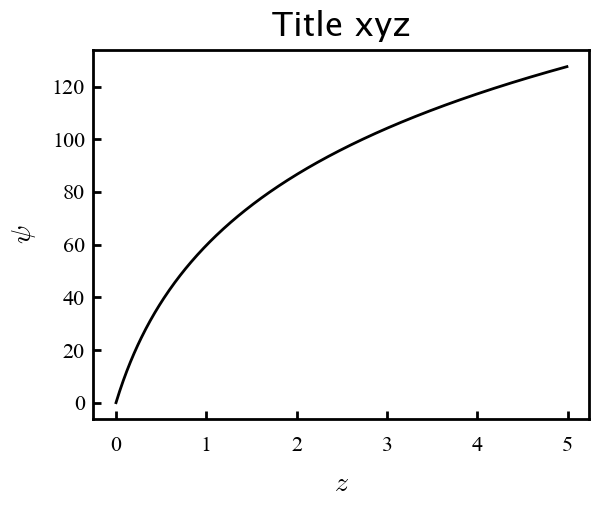

In [4]:
# Analytical, compare with 'soft condensed matter...' textbook, andelman chapter
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*298, 1.6e-19
A = 1

surf_c = -e/2e-09 # C/nm2

lGC = 2*eps0*epsw*kBT/e/abs(surf_c)
psi0 = -2*np.log(lGC)
print(kBT/e)

psi = lambda z: 2*np.log(z+lGC)+psi0
z = np.arange(0,5,0.01)
plt.plot(z, psi(z)*25.7, 'k')

plt.title('Title xyz')
plt.ylabel(r'$\psi$')
plt.xlabel(r'$z$')
tjy.ticks()

# PREV

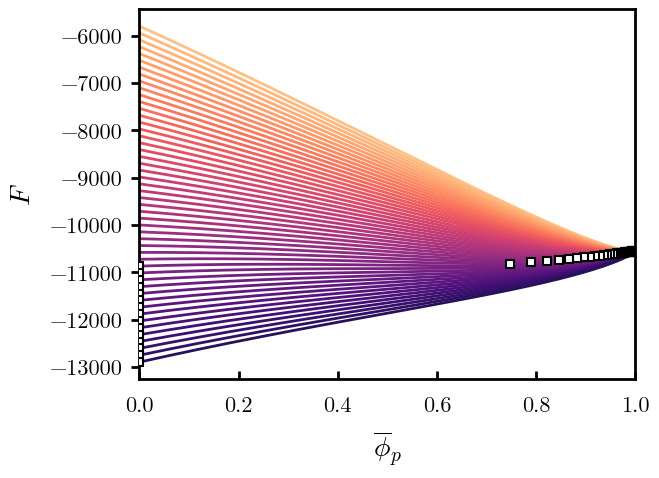

In [2]:
mcs = mpl.colormaps['magma'].resampled(70)(range(60,0,-1))
ccycle = iter(mcs)

def Solve_SCF(mu_w, n_p, N, V, nu):
    chi = 1.00
    
    phi_p = n_p*N*nu/V
    phi_w = 1-phi_p
    w_w   = mu_w - np.log(phi_w)
    eta   = chi*phi_p - w_w
    w_p   = chi*phi_w - eta
    Q_w   = V/nu * np.exp(-w_w)
    Q_p   = V/nu * np.exp(-w_p)
    
    f = -np.exp(mu_w)*Q_w - n_p*N*np.log(Q_p) + V/nu*(chi*phi_p*phi_w - w_p*phi_p - w_w*phi_w) #+ np.log(float(np.math.factorial(int(n_p))))
    return phi_p, f

zeros = []
mu_ws = np.arange(3.00, 8.00, 0.10)
for mu_w in mu_ws:
    N, V, nu = 50, 100, 0.069 # [1], [nm3], [nm3]

    phi_ps, fs = [], []
    for n_p in np.arange(0,V/(nu*N),0.05):
        phi_p, f = Solve_SCF(mu_w, n_p, N, V, nu)
        phi_ps.append(phi_p)
        fs.append(f)
    curve = UnivariateSpline(phi_ps, fs, s=1e-04, k=4)
    zero = curve.derivative(1).roots()
    left, right = float(curve(0)), float(curve(1)) # Extremeties
    fil = lambda x: x[np.argmin(curve(x))] # Find location of minimum
    if    zero.size==1: zero = fil([0,1,zero[0]])
    elif  zero.size==2: zero = fil([0,1,zero[0],zero[1]])
    else: zero = fil([0,1])
    zeros.append(zero)

    plt.plot(phi_ps, curve(phi_ps), label='_'+str(mu_w), c=next(ccycle))
    plt.plot(zero, curve(zero), 's', markerfacecolor='white', c='k', zorder=5)

# plt.legend(loc=(1.07,0.05), title=r'$\mu_w$', title_fontsize=20, ncols=2)
plt.xlim(0.0,1.0)
plt.xlabel(r'$\overline{\phi}_p$')
plt.ylabel(r'$F$')
tjy.ticks()

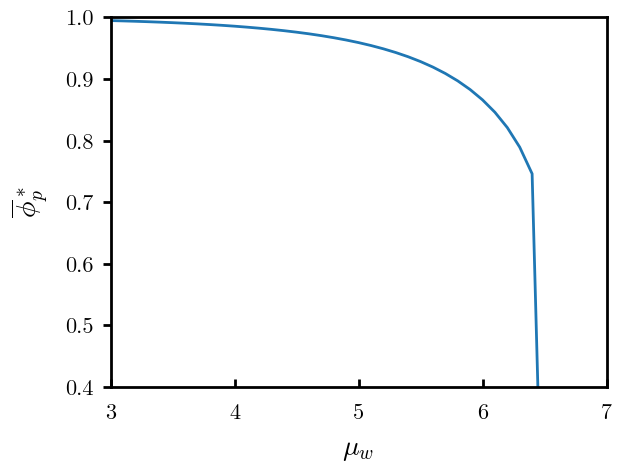

In [4]:
plt.plot(mu_ws, zeros)

plt.ylim(0.4,1)
plt.xlim(3.00, 7.00)
plt.xlabel(r'$\mu_w$')
plt.ylabel(r'$\overline{\phi}_p^*$')
tjy.ticks()

In [2]:
def Process(fname):
    data = pd.read_csv(fname, names=np.arange(12), sep='\s+')
    thetas, nd = [], []
    for i in range(len(data)):
        if i%2: thetas += [data.iloc[i,5]] # Vol dens of block 2 adj. to surf
        else:   nd += [data.iloc[i,:6].to_list()]
    return pd.concat([pd.DataFrame(nd,  columns=['it', 'lx', 'free', 'freeDiff', 'inCompMax', 'andErr']), pd.Series(thetas, name='theta')], axis=1)

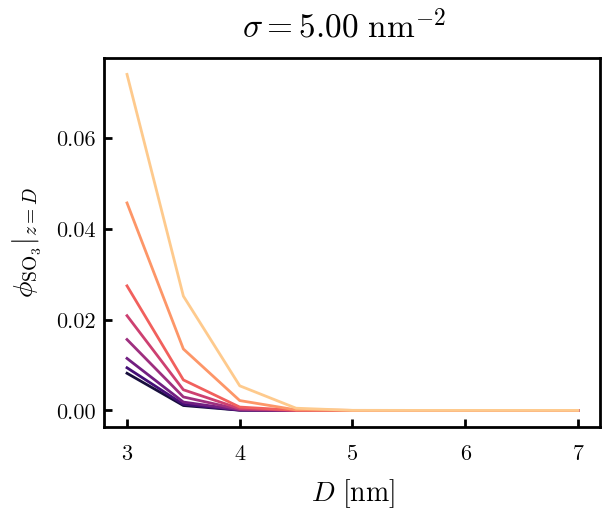

In [23]:
lx30, lx35, lx40, lx45 = Process(GIT+'s500_lx30.txt'), Process(GIT+'s500_lx35.txt'), Process(GIT+'s500_lx40.txt'), Process(GIT+'s500_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s500_lx50.txt'), Process(GIT+'s500_lx55.txt'), Process(GIT+'s500_lx60.txt'), Process(GIT+'s500_lx65.txt'), Process(GIT+'s500_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

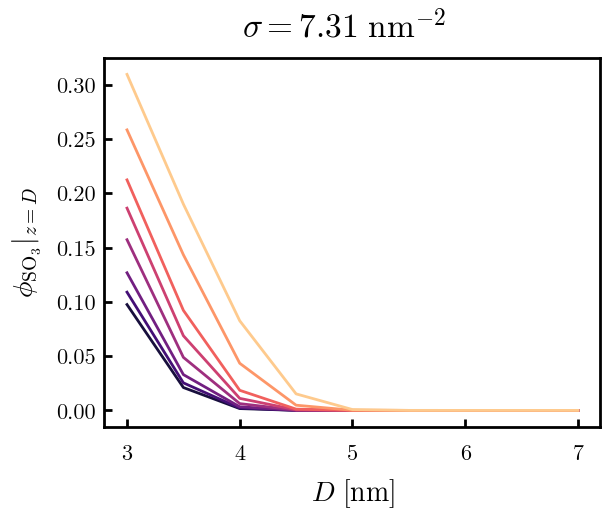

In [22]:
lx30, lx35, lx40, lx45 = Process(GIT+'s731_lx30.txt'), Process(GIT+'s731_lx35.txt'), Process(GIT+'s731_lx40.txt'), Process(GIT+'s731_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s731_lx50.txt'), Process(GIT+'s731_lx55.txt'), Process(GIT+'s731_lx60.txt'), Process(GIT+'s731_lx65.txt'), Process(GIT+'s731_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

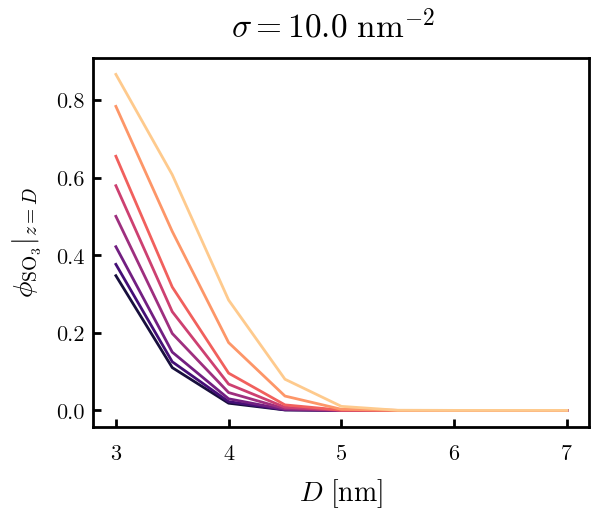

In [21]:
lx30, lx35, lx40, lx45 = Process(GIT+'s1000_lx30.txt'), Process(GIT+'s1000_lx35.txt'), Process(GIT+'s1000_lx40.txt'), Process(GIT+'s1000_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s1000_lx50.txt'), Process(GIT+'s1000_lx55.txt'), Process(GIT+'s1000_lx60.txt'), Process(GIT+'s1000_lx65.txt'), Process(GIT+'s1000_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

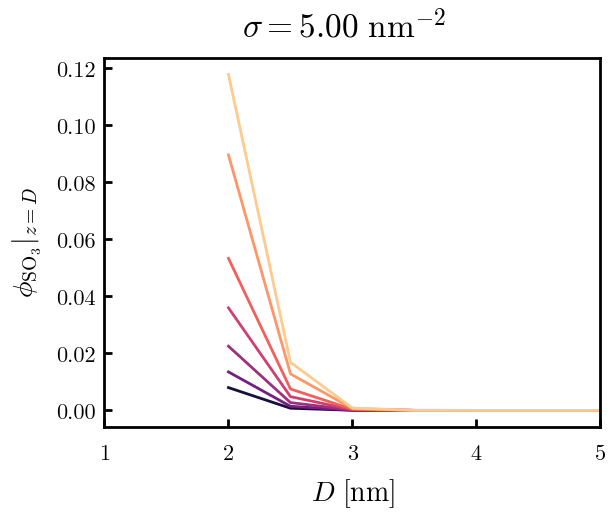

In [45]:
cs = 'c100_'
ss = 's500_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim = (1, 5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

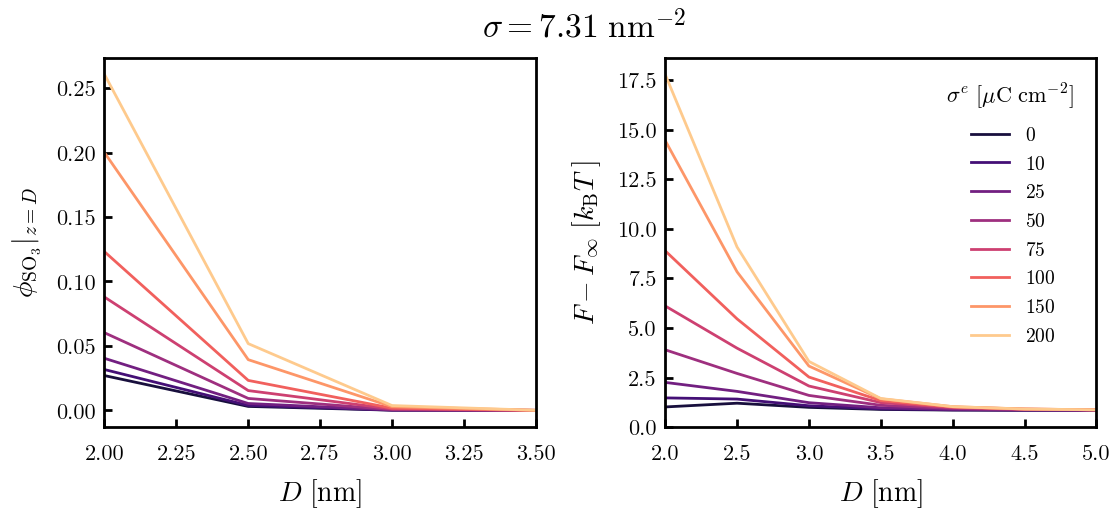

In [187]:
cs,cbulk = 'c100_', 0.1 * 1000 * 6.02e23 / 1e27 *2
ss = 's731_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
# ax = [ax]
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y-y[-1] + cbulk*x, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (2, 3.5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim= (2, 5)
)
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

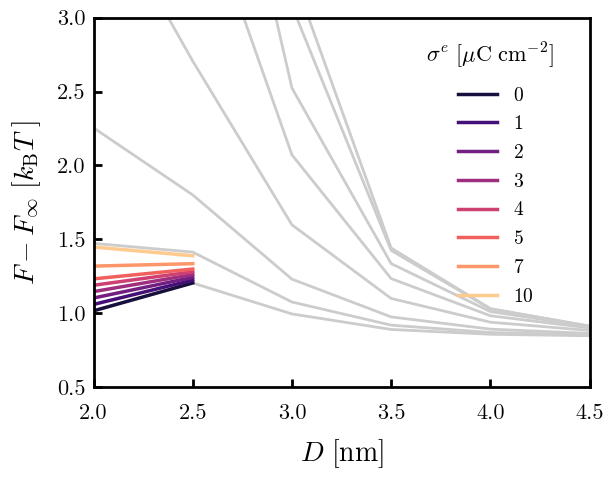

In [127]:
bulk = lx70
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    plt.plot(x, y-bulk.free[ind] + cbulk*x, label='_${}$'.format(i), color='0.8')
    
kws = {'names':['it', 'lx', 'free', 'x', 'xx', 'xxx'], 'sep':'\s+'}
data = pd.read_csv(GIT+'new-lx15.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data1= pd.read_csv(GIT+'new-lx20.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data2= pd.read_csv(GIT+'new-lx25.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')

for ind,i in enumerate([0,1,2,3,4,5,7,10]):
    x=np.array([i.lx[0] for i in [data, data1, data2]])[1:3]
    y=[i.free[ind] for i in [data,data1,data2]][1:3]
    plt.plot(x,y-bulk.free[0]+cbulk*x, label='${}$'.format(i), color=mcs[ind], marker='', lw=2.5)
    
plt.gca().set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim=(2,4.5),
    ylim=(0.5,3)
)
plt.text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=plt.gca().transAxes, fontsize=16, ha='center')
plt.legend(loc=(0.72,0.2))
tjy.ticks()

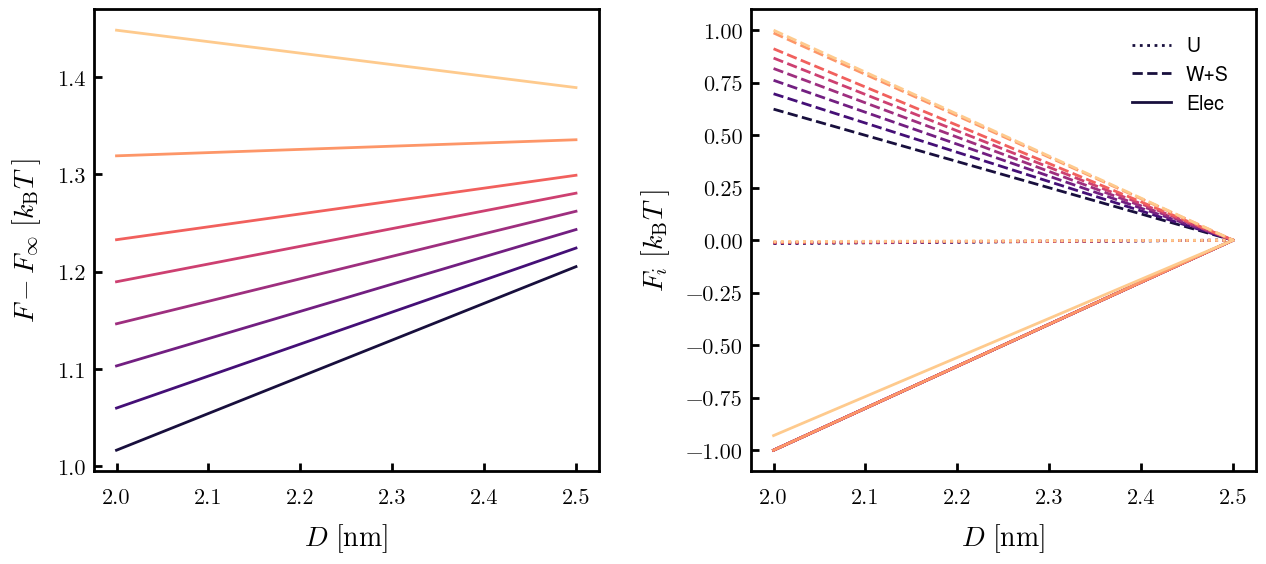

In [185]:
lx25fs = pd.DataFrame([
    [0,  2.500e+00, -4.70644e+01, 1.42445e-01, -5.70074e+01, -1.00664e+01, 2.01681e+01, -3.01100e-01],
    [1,  2.500e+00, -4.70453e+01, 1.42697e-01, -5.69071e+01, -1.01076e+01, 2.01279e+01, -3.01100e-01],
    [2,  2.500e+00, -4.70263e+01, 1.42951e-01, -5.68055e+01, -1.01494e+01, 2.00867e+01, -3.01100e-01],
    [3,  2.500e+00, -4.70075e+01, 1.43208e-01, -5.67026e+01, -1.01915e+01, 2.00445e+01, -3.01100e-01],
    [4,  2.500e+00, -4.69889e+01, 1.43469e-01, -5.65984e+01, -1.02342e+01, 2.00013e+01, -3.01100e-01],
    [5,  2.500e+00, -4.69705e+01, 1.43732e-01, -5.64929e+01, -1.02772e+01, 1.99570e+01, -3.01100e-01],
    [7,  2.500e+00, -4.69340e+01, 1.44269e-01, -5.62778e+01, -1.03647e+01, 1.98653e+01, -3.01100e-01],
    [10, 2.500e+00, -4.68804e+01, 1.45097e-01, -5.59451e+01, -1.04994e+01, 1.97200e+01, -3.01100e-01],
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])
lx20fs = pd.DataFrame([
    [0,  2.000e+00, -4.71928e+01, 1.34811e-01, -7.39004e+01, 7.12726e+00, 1.96863e+01, -2.40880e-01],
    [1,  2.000e+00, -4.71495e+01, 1.35207e-01, -7.36954e+01, 7.04242e+00, 1.96091e+01, -2.40880e-01],
    [2,  2.000e+00, -4.71062e+01, 1.35607e-01, -7.34882e+01, 6.95684e+00, 1.95305e+01, -2.40880e-01],
    [3,  2.000e+00, -4.70629e+01, 1.36010e-01, -7.32789e+01, 6.87055e+00, 1.94503e+01, -2.40880e-01],
    [4,  2.000e+00, -4.70197e+01, 1.36418e-01, -7.30675e+01, 6.78354e+00, 1.93687e+01, -2.40880e-01],
    [5,  2.000e+00, -4.69765e+01, 1.36829e-01, -7.28539e+01, 6.69581e+00, 1.92856e+01, -2.40880e-01],
    [7,  2.000e+00, -4.68903e+01, 1.37662e-01, -7.24202e+01, 6.51825e+00, 1.91149e+01, -2.40880e-01],
    [10, 2.000e+00, -4.67612e+01, 1.38939e-01, -7.17533e+01, 6.24658e+00, 1.88475e+01, -2.40880e-01], 
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])

lxfs = [lx20fs, lx25fs]
end = 1
rel = lambda x: np.array(x) - x[end]
fig, axs = plt.subplots(1,2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.3)
for ind,i in enumerate(lx25fs.surf):
    x = [i.lx[0] for i in lxfs]
    y0= [i.free[ind]-i.bulk[ind]-bulk.free[0] for i in lxfs]
    axs[0].plot(x,y0, label='${}$'.format(i), color=mcs[ind])
    
    rU, rWS, rE = rel([i.U[ind] for i in lxfs]), rel([i.W[ind]+i.S[ind] for i in lxfs]), rel([i.elec[ind] for i in lxfs])
    maxm = np.max([np.max(np.abs(rU)), np.max(np.abs(rWS)), np.max(np.abs(rE))])
    if maxm!=0: 
        axs[1].plot(x,rU/maxm, color=mcs[ind], ls=':', label='U')
        axs[1].plot(x,rWS/maxm,color=mcs[ind], ls='--', label='W+S')
        axs[1].plot(x,rE/maxm, color=mcs[ind], label='Elec')
    
axs[0].set(
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlabel=r'$D\ [\mathrm{nm}]$'
)
axs[1].set(
    ylim=(-1.1,1.1),
    ylabel=r'$F_i\ [k_\mathrm{B}T\ ]$',
    xlabel=r'$D\ [\mathrm{nm}]$'
)
h, l = axs[1].get_legend_handles_labels()
axs[1].legend(handles=h[:3], labels=l[:3])
tjy.ticks(axs)

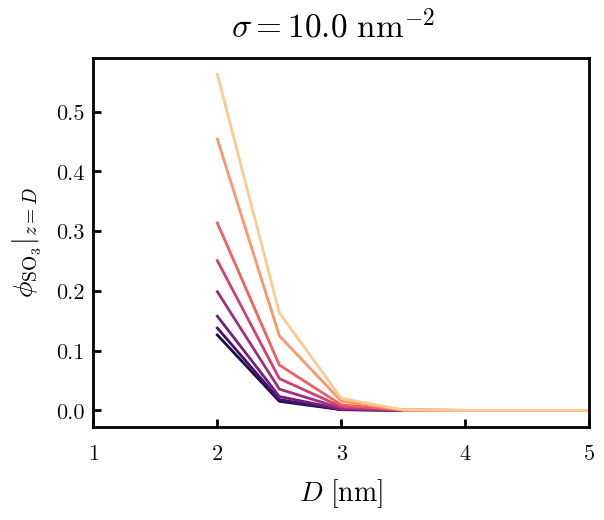

In [48]:
cs = 'c100_'
ss = 's1000_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (1, 5),
    # yscale= 'log',
    # ylim= (1e-03, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

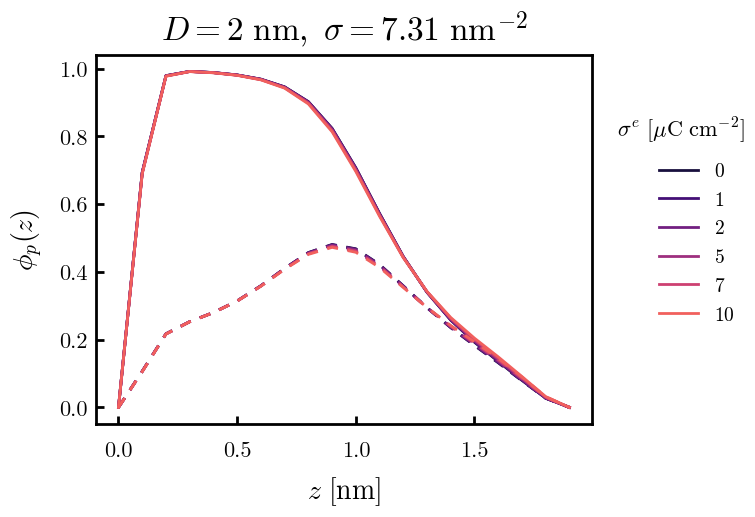

In [93]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'ph_new-lx200e'

fig, ax = plt.subplots(1,1)
for i,c in zip(['000', '001', '002', '005', '007', '010'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    # xlim= (1.4, 1.8),
    # ylim= (0, 0.30),
)    

ax.text(1.18, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.12,0.25), ncol=1)

plt.title(r'$D=2\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks()

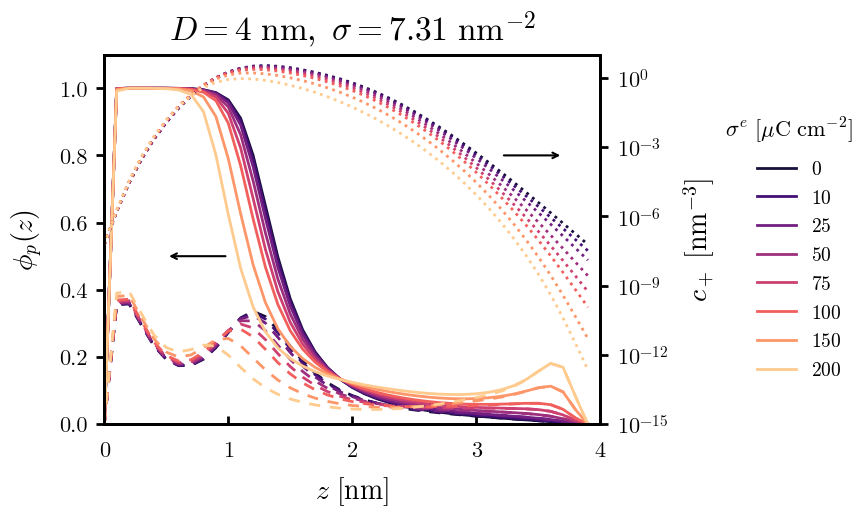

In [3]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731_lx400e'
eat = 'els731_lx400e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 4),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-15, 1e1)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=4\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])

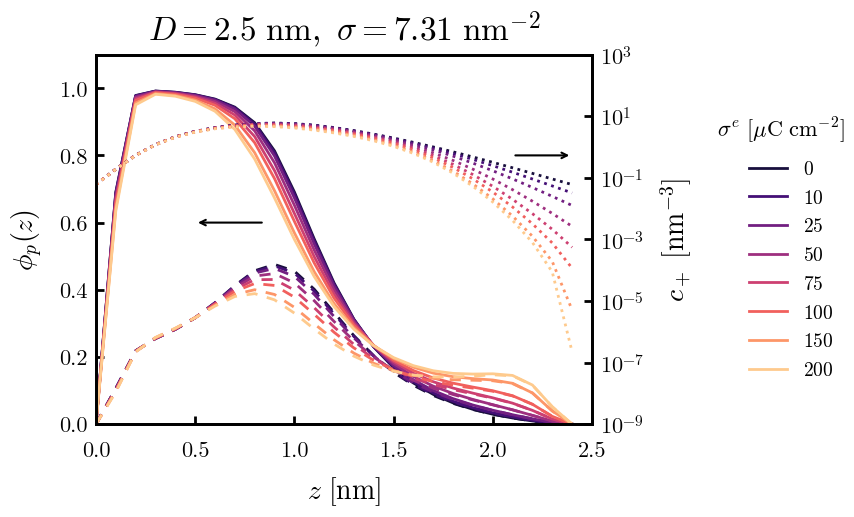

In [77]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731c100_lx250e'
eat = 'els731c100_lx250e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.50, 0.6), xytext=(0.85, 0.6),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(2.4, 0.8), xytext=(2.1, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 2.5),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-9, 1e3)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=2.5\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])